# Cross-species muscle

Matplotlib Backend: module://ipykernel.pylab.backend_inline
-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
anndata             0.7.5
autoreload          NA
backcall            0.1.0
cairo               1.18.2
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.1
get_version         2.1
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.19
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     0.0.0
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.1.2
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.3
packaging           20.8
pandas              1.1.4
parso               0.5.1
pexpect             4.7.0
pickleshare         0

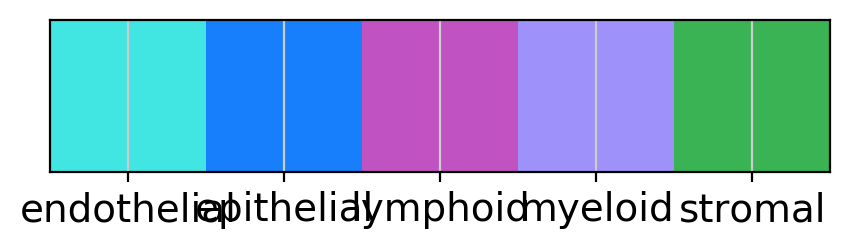

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import glob
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scanpy as sc
import yaml


sys.path.append('/home/olga/code/xspecies--olgabot/refactor-bladder-blood-lung-muscle/xspecies/')

# Handwritten modules
import preprocess
from plot_utils import save_figures

## Constants

In [2]:
tissue = 'muscle'


umap_plot_kws = dict(color=['species', 'compartment_group', 'broad_group'], ncols=2)
celltype_col = 'narrow_group'
species_col = 'species'
compartment_col = 'compartment_group'

object_dir = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species'

output_file = os.path.join(object_dir, f'concatenated__human-lemur-mouse_10x__one2one_orthologs__{tissue}__april2021__preprocessed.h5ad')

min_cells_per_celltype = 20

## Set scanpy savefig options

In [3]:

xspecies_figure_folder = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species--bladder-blood-lung-muscle'

figure_folder = os.path.join(xspecies_figure_folder, tissue, 'preprocess')

sc._settings.ScanpyConfig(autosave=True, figdir=figure_folder, autoshow=True)
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "Arial"

sc.settings.autosave = True
sc.settings.autoshow = True
sc.settings.figdir = figure_folder

# Load data

## Unprocessed data

In [4]:
object_dir = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species' 
h5ad = os.path.join(object_dir, f'concatenated__human-lemur-mouse_10x__one2one_orthologs__{tissue}__april2021.h5ad')
adata = sc.read(h5ad, cache=True)

adata

AnnData object with n_obs × n_vars = 35263 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'channel', 'sequencing_run', 'cell_barcode', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'batch', 'cell_id_v1', 'cell_id_v2', 'species_batch'
    var: 'mouse_lemur__gene_name-human_hlca', 'mouse__gene_name-human_hlca', 'ensembl_id-human_sapiens', 'len-human_sapiens', 'mouse_lemur__gene_name-lemur', 'mouse__gene_name-lemur', 'name-lemur', 'highly_variable-lemur', 'mouse_lemur__gene_name-mouse_ce', 'mouse__gene_name-mouse_ce', 'n_cells-mouse_tabula_muris_senis', 'mouse_lemur__gene_name-mouse_tabula_muris_senis', 'mouse__gene_name-mouse_tabula_muris_senis'

In [5]:
adata.obs.groupby(['narrow_group', 'species']).size().unstack()

species                                    Human  Mouse  Mouse lemur
narrow_group                                                        
B cell                                         5    810          201
CD4+ T cell                                    0     94          781
CD8+ T cell                                    0    230          290
Schwann cell                                   0    166            0
T cell                                       169    178            0
T reg cell                                     0     54            0
adipocyte                                      0      0           24
artery cell                                    0   1029            3
basophil                                       0      5            5
capillary cell                              1702   2457          439
classical monocyte                             0    240            0
conventional dendritic cell                    0    106            0
dendritic cell (MREG+)                         0     25            0
doublet                                        0   1103          157
endothelial cell                            1206      0            0
erythroid lineage cell                        11     14           10
fast muscle cell                             229    142           45
innate lymphoid cell                           0     24            0
lymphatic cell                                31    261           20
macrophage                                   740    731          148
mesenchymal cell                            5976   6884          542
natural killer T cell                         32      0            8
natural killer cell                            0     14            0
neutrophil                                     0    105           52
non-classical monocyte                         0     50            0
pericyte cell                                631    156          104
plasma cell                                    0     52           31
plasmacytoid dendritic cell                    0     10            0
proliferating B cell                           0      6           12
proliferating CD4+ T cell                      0      6            0
proliferating CD8+ T cell                      0      5            0
proliferating conventional dendritic cell      0     14            0
proliferating natural killer cell_T cell       0      0           13
proliferating neutrophil                       0     27            0
proliferating plasma cell                      0      0            2
reticular cell                                 0      0           19
skeletal muscle cell                           7      0            0
skeletal muscle satellite stem cell         2121   1170           86
slow muscle cell                              38      4           18
smooth muscle cell                             0    241            0
tendon cell                                   76   1981           51
vascular associated smooth muscle cell         0     12           17
vein cell                                      0    758           47

## Remove color palettes

In [6]:
preprocess.remove_color_palettes(adata)

## Ignore macrophages

Mouse macrophages are a mix of neutrophils and macrophages, so ignore

In [7]:
celltypes_to_ignore = 'macrophage',

In [8]:
adata = adata[~adata.obs.narrow_group.isin(celltypes_to_ignore)]
adata

View of AnnData object with n_obs × n_vars = 33644 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'channel', 'sequencing_run', 'cell_barcode', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'batch', 'cell_id_v1', 'cell_id_v2', 'species_batch'
    var: 'mouse_lemur__gene_name-human_hlca', 'mouse__gene_name-human_hlca', 'ensembl_id-human_sapiens', 'len-human_sapiens', 'mouse_lemur__gene_name-lemur', 'mouse__gene_name-lemur', 'name-lemur', 'highly_variable-lemur', 'mouse_lemur__gene_name-mouse_ce', 'mouse__gene_name-mouse_ce', 'n_cells-mouse_tabula_muris_senis', 'mouse_lemur__gene_name-mouse_tabula_muris_senis', 'mouse__gene_name-mouse_tabula_muris_senis'

### Delete all existing color palettes because they mess plotting up

In [9]:
for key in list(adata.uns.keys()):
    if key.endswith('colors'):
        del adata.uns[key]

In [10]:
adata.uns

{}

In [11]:
preprocess.plot_constants.SPECIES_PALETTE

['#ff7f0e', '#2ca02c', '#1f77b4']

In [12]:
adata.uns['species_colors'] = preprocess.plot_constants.SPECIES_PALETTE

Trying to set attribute `.uns` of view, copying.


... storing 'compartment_broad' as categorical
... storing 'compartment_narrow' as categorical
... storing 'compartment_broad_narrow' as categorical
... storing 'compartment_species' as categorical
... storing 'compartment_narrow_species' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


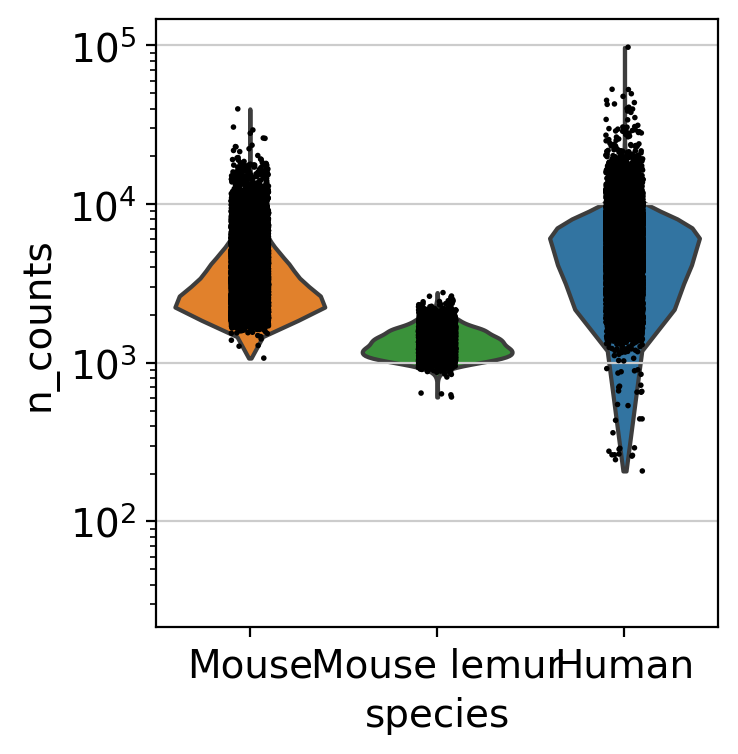

<Figure size 800x800 with 0 Axes>

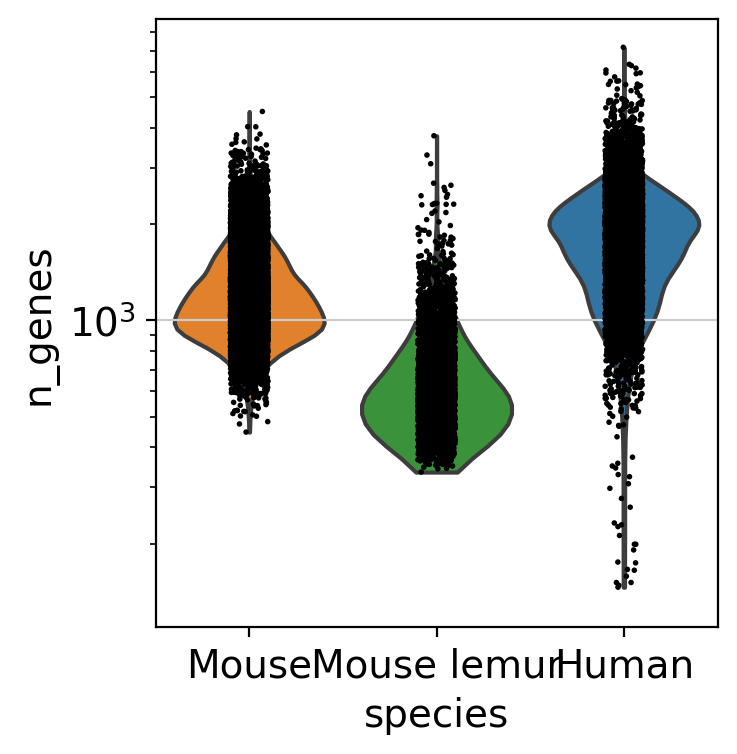

<Figure size 800x800 with 0 Axes>

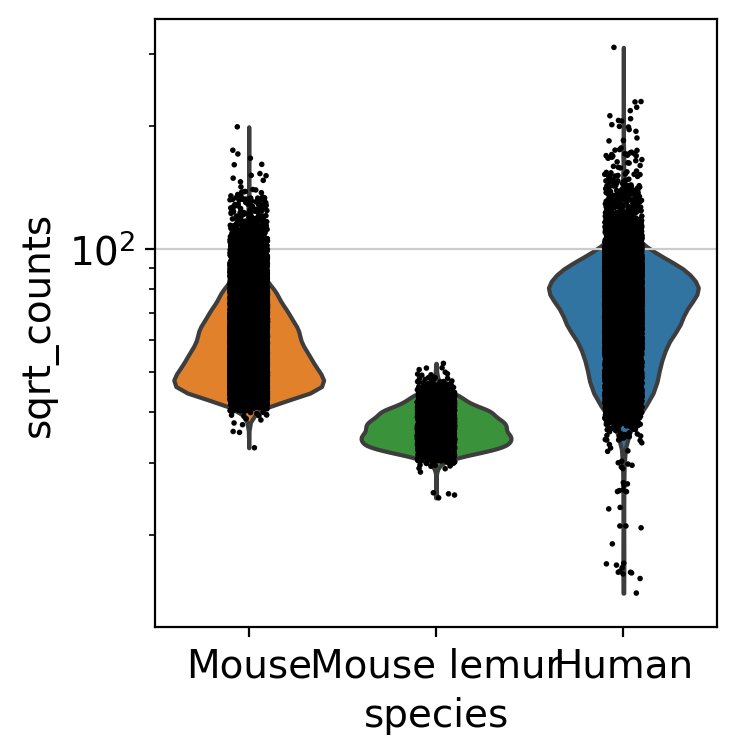

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<Figure size 800x800 with 0 Axes>

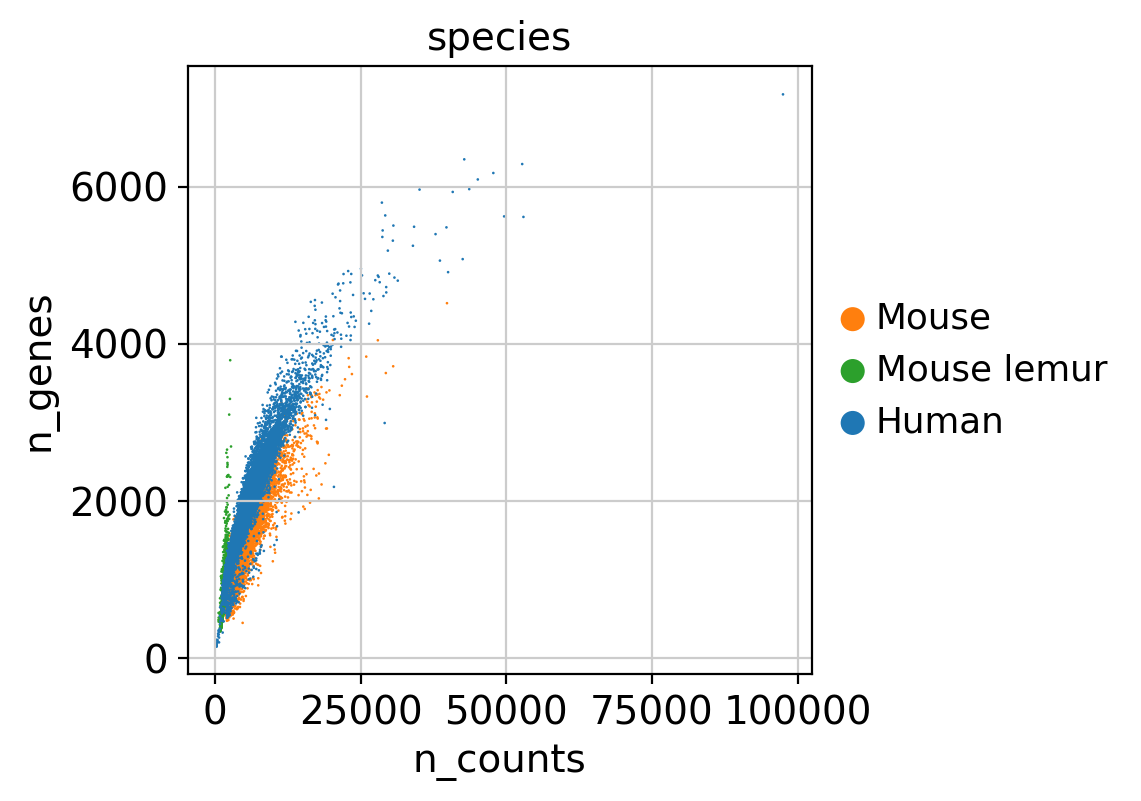

<Figure size 800x800 with 0 Axes>

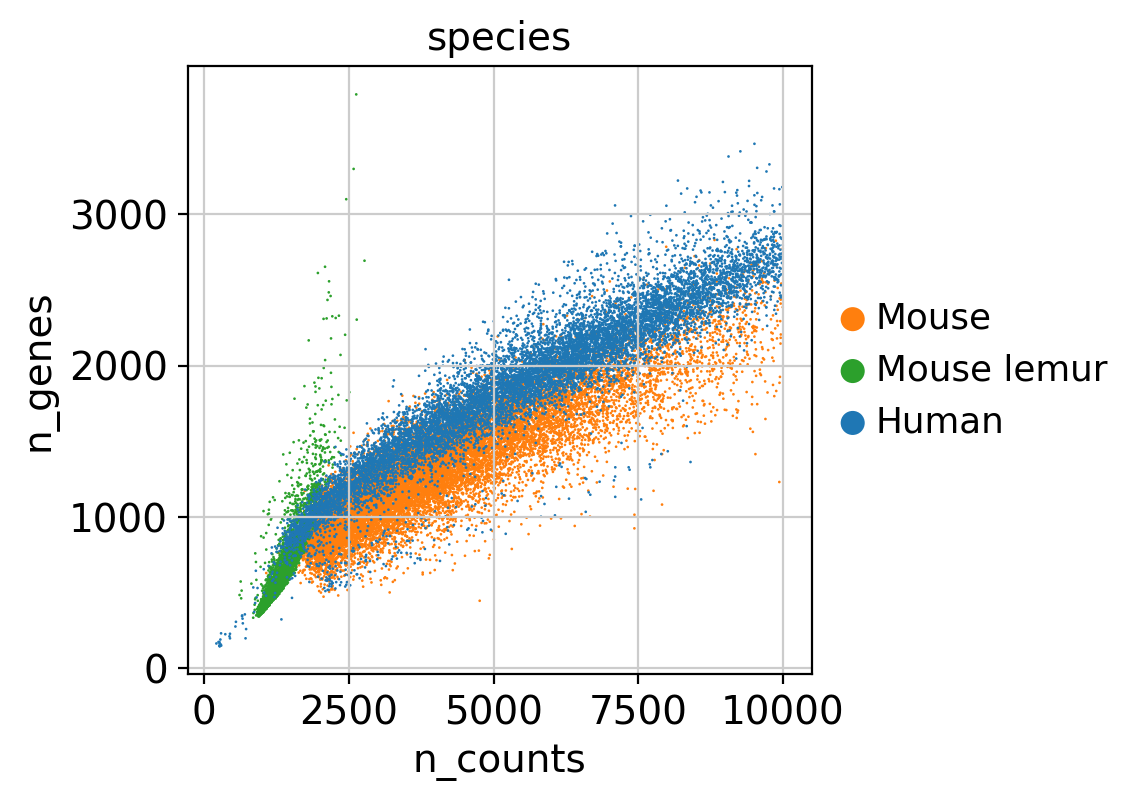

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 800x800 with 0 Axes>

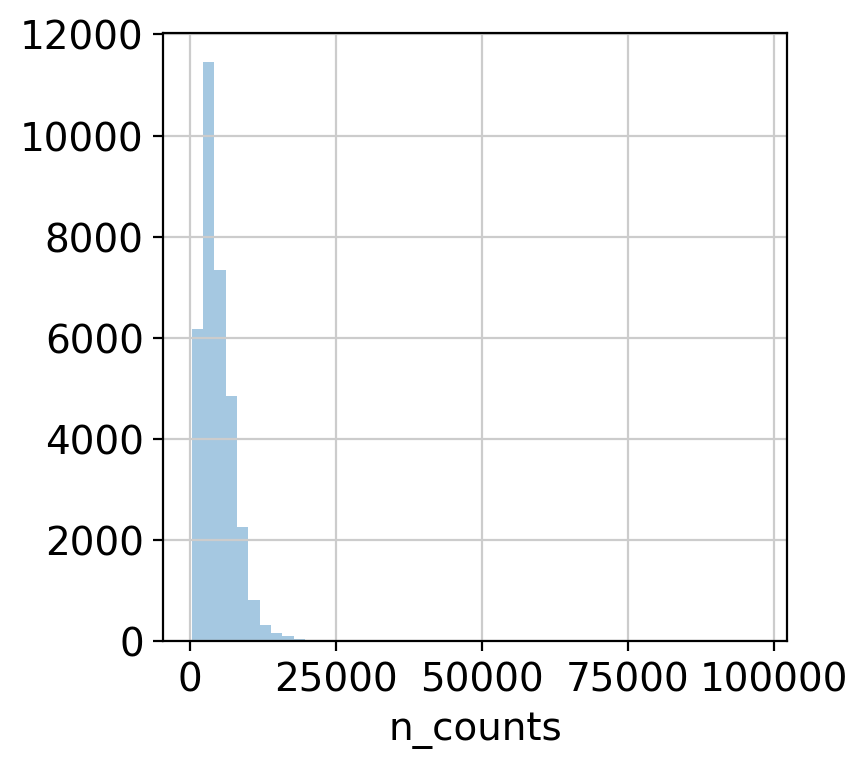

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


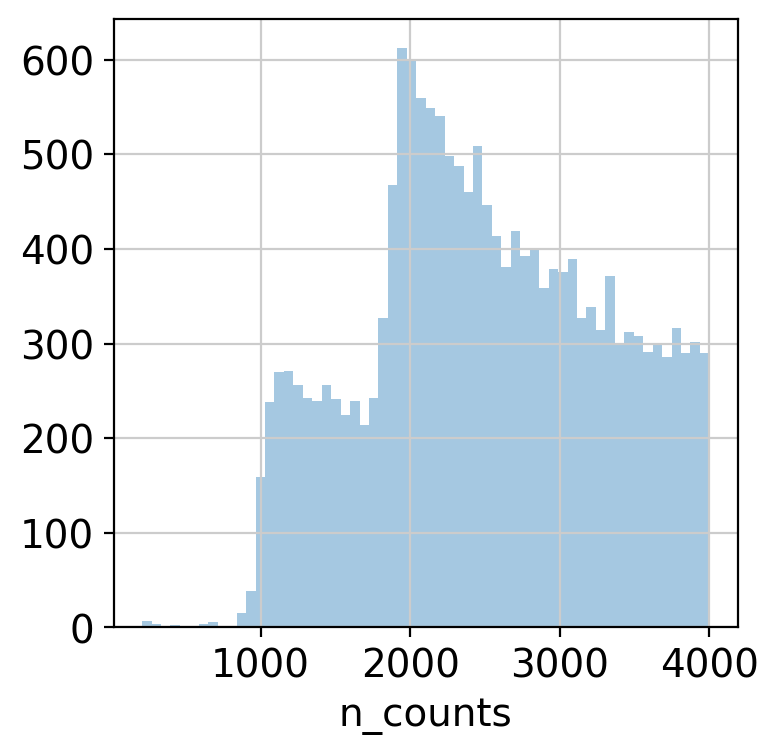

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


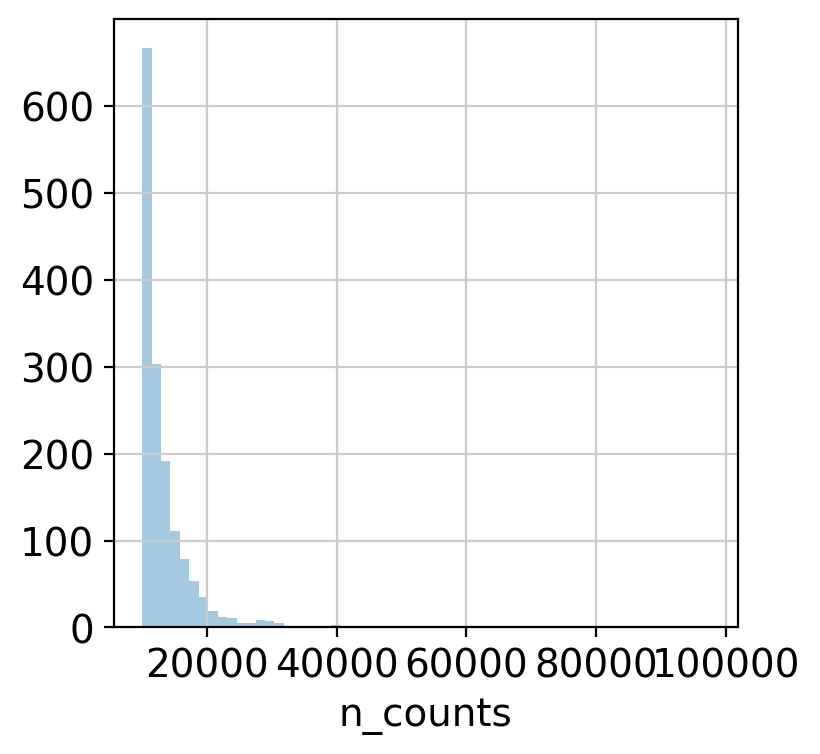

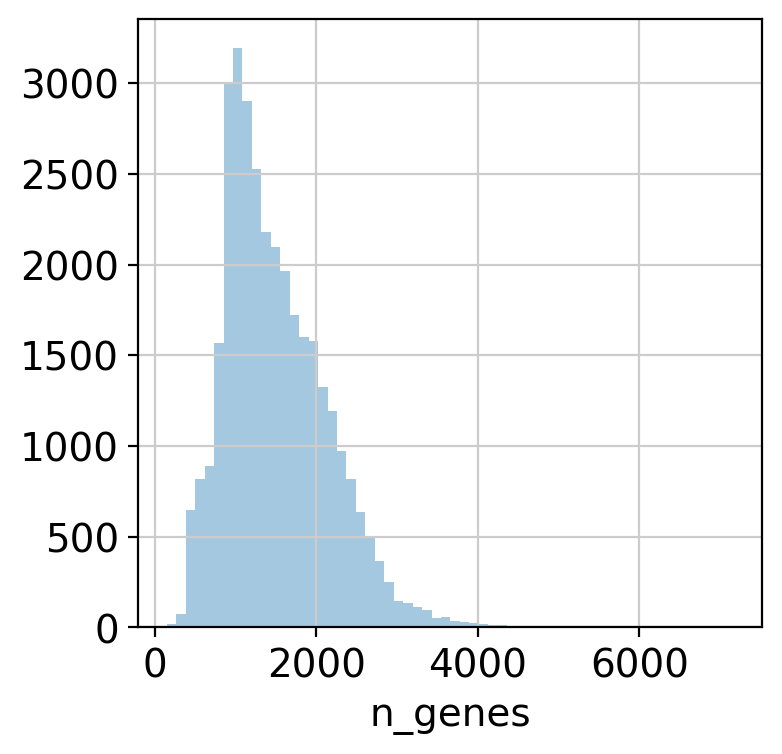

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


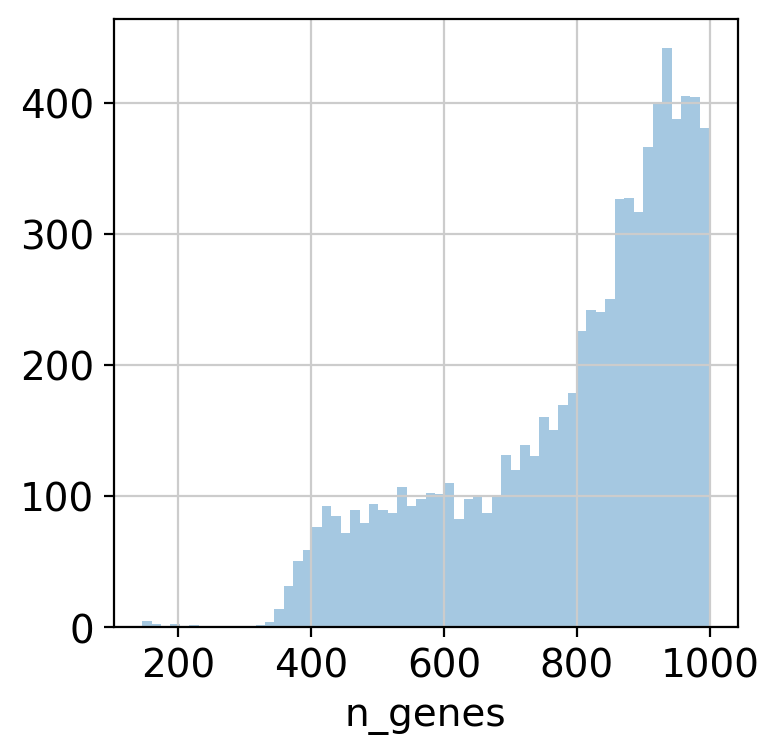

filtered out 155 cells that have less than 1000 counts


Total number of cells: 33644
Number of cells after min count filter: 33489
Number of cells after gene filter: 33489
Total number of genes: 13302


filtered out 423 genes that are detected in less than 3 cells
normalizing counts per cell


Number of genes after cell filter: 12879


    finished (0:00:00)


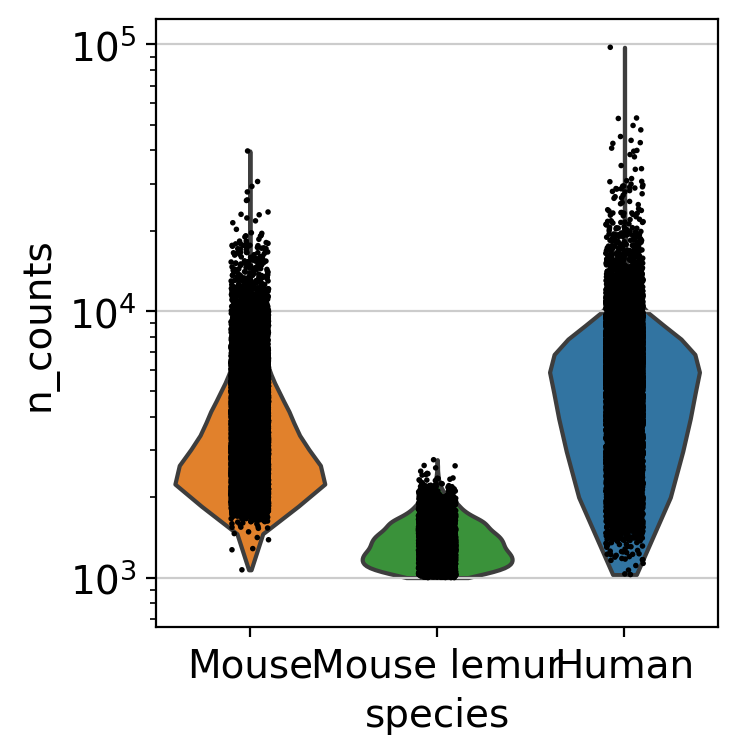

<Figure size 800x800 with 0 Axes>

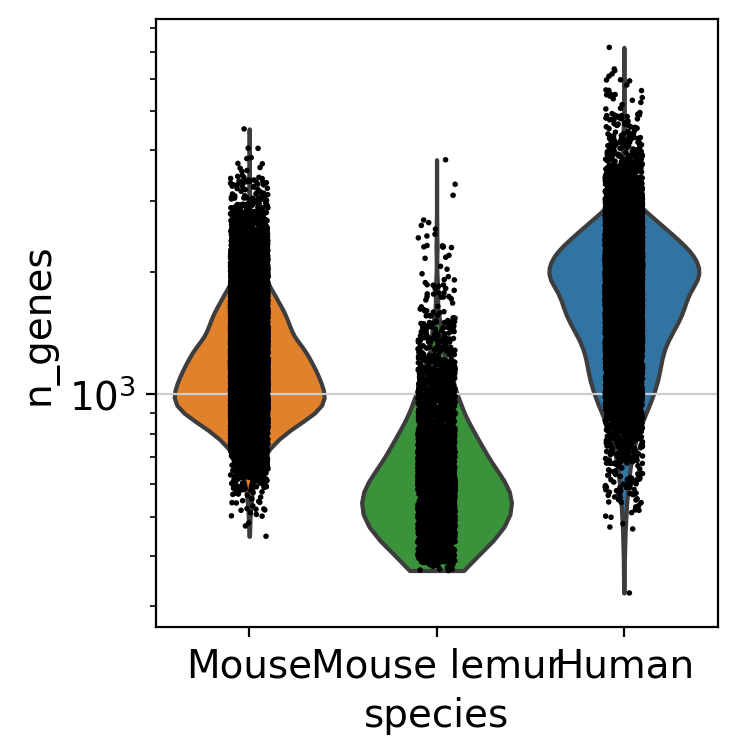

<Figure size 800x800 with 0 Axes>

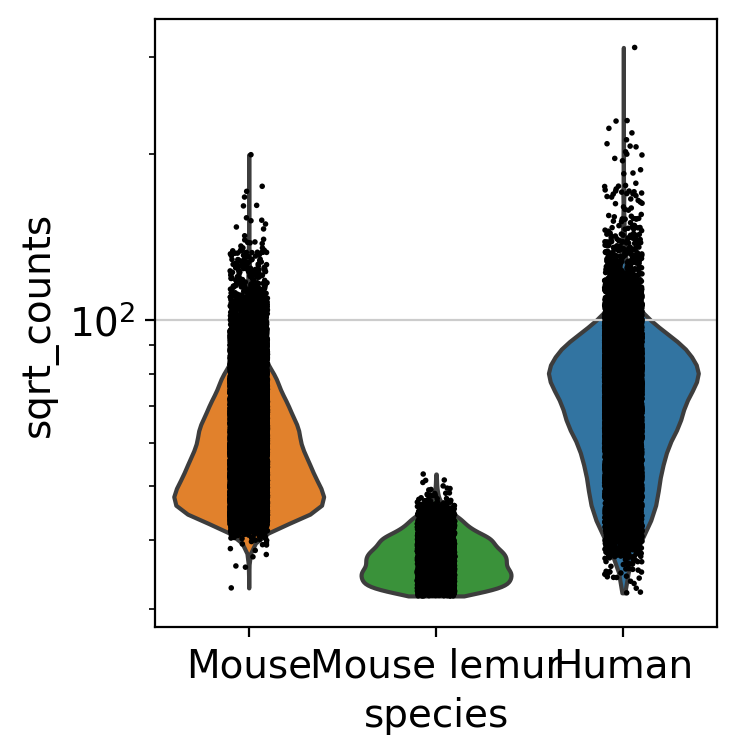

<Figure size 800x800 with 0 Axes>

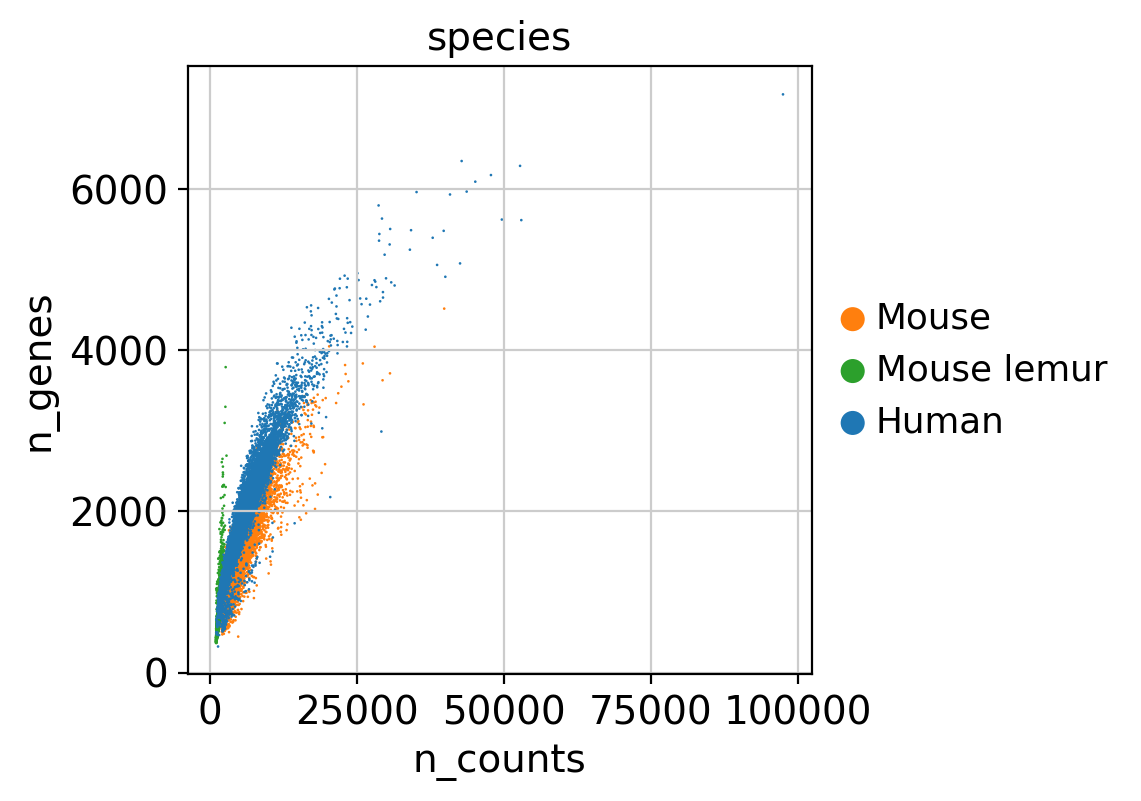

<Figure size 800x800 with 0 Axes>

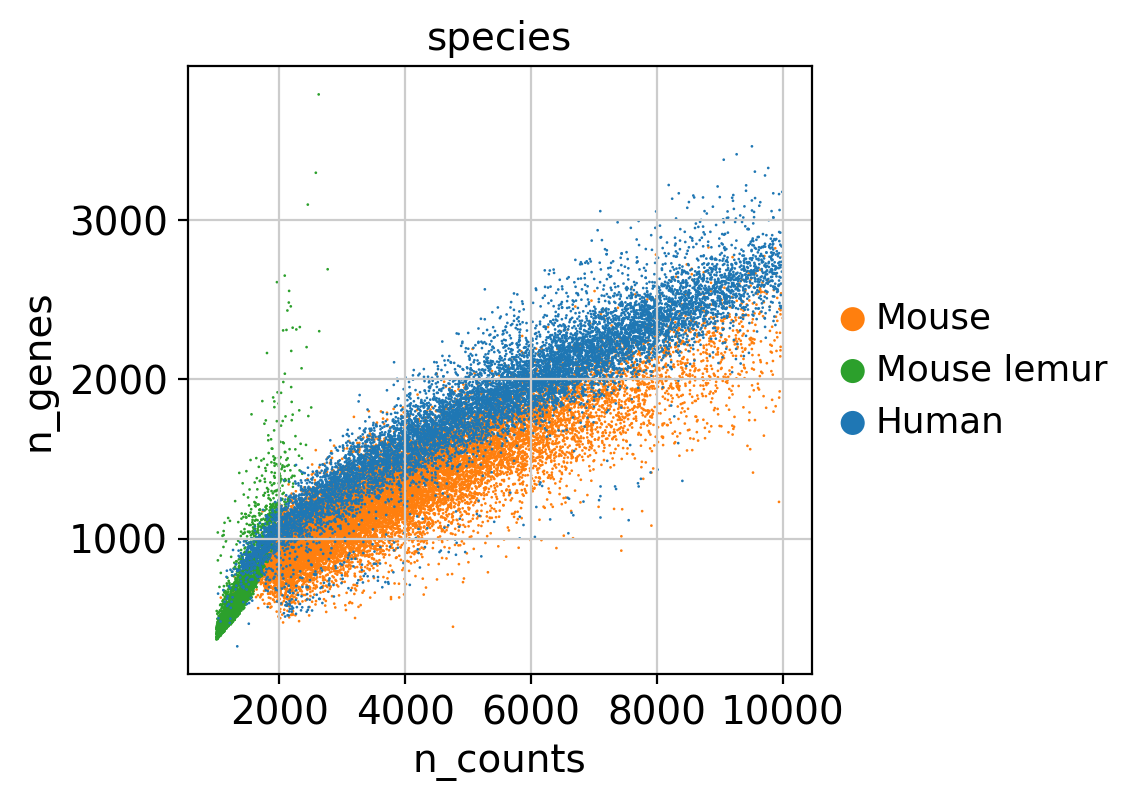

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 800x800 with 0 Axes>

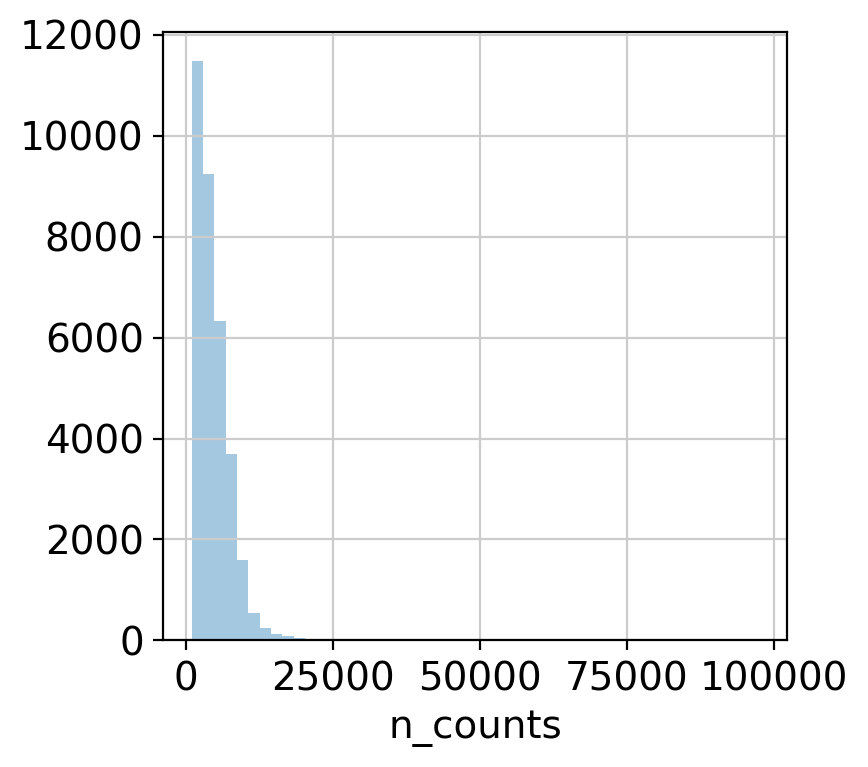

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


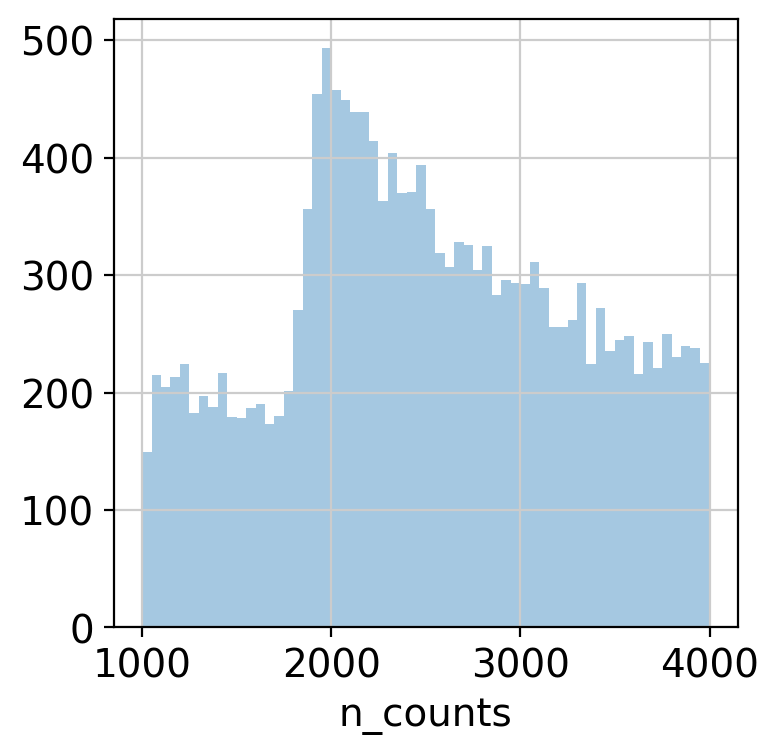

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


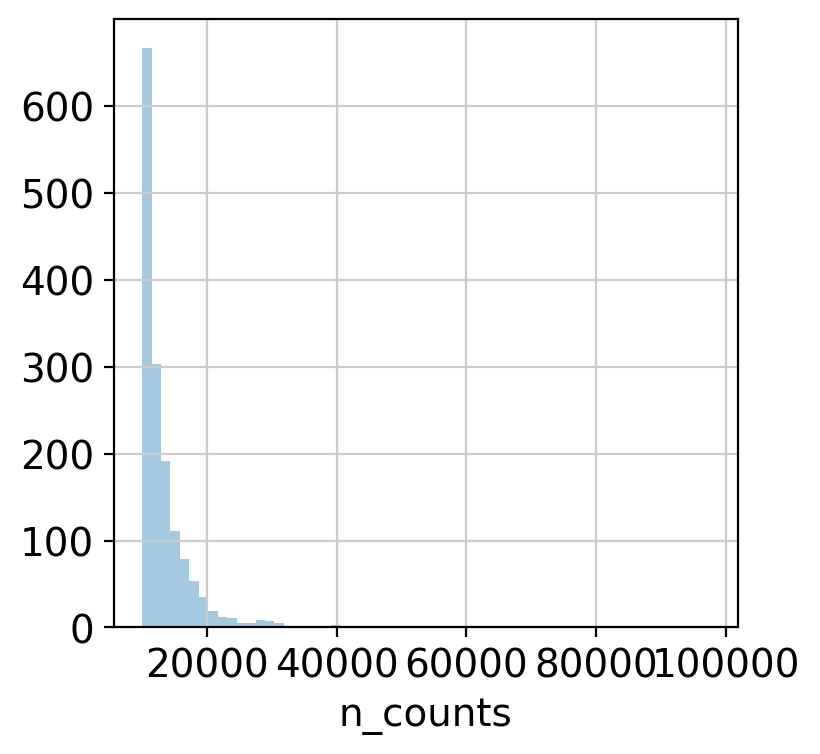

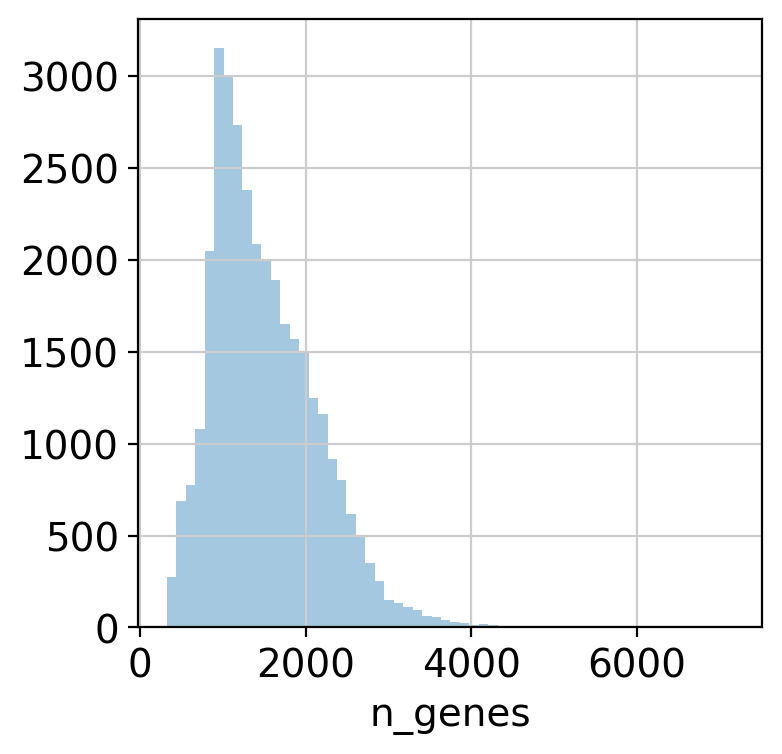

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


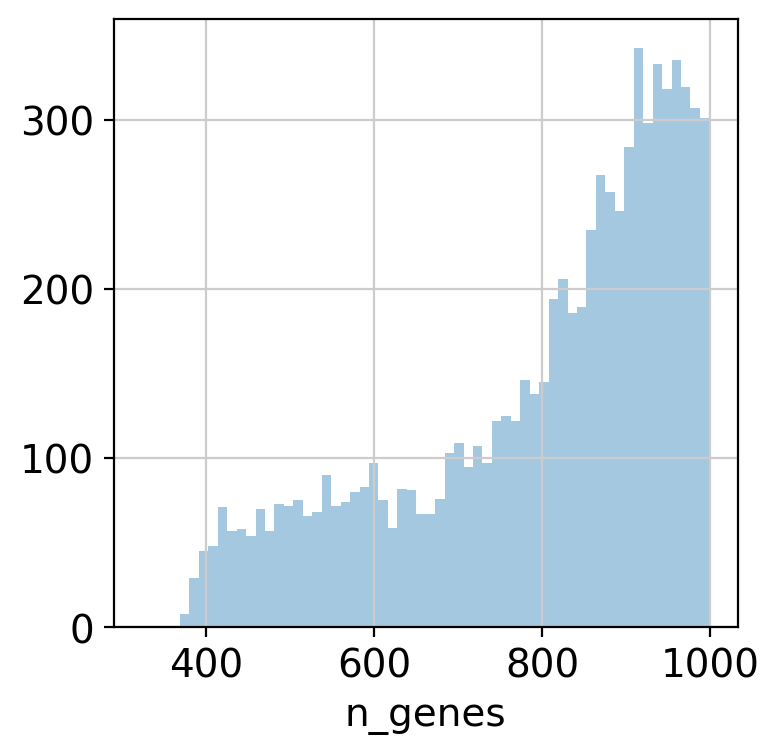

In [13]:
adata = preprocess.add_compartment_combined_cols(adata)
adata = preprocess.filter_genes_cells(adata)


# Filter min cells per group

In [14]:


adata = preprocess.filter_min_cells_per_group(
    adata,
    celltype_col=celltype_col,
    species_col=species_col,
    min_cells_per_celltype=5,
)


Filtering for celltype column narrow_group with at least 5 cells per species
--- Before filtering ---
-- Number of cell types: 42 --
narrow_group                               species    
B cell                                     Mouse           810
                                           Mouse lemur     181
                                           Human             5
CD4+ T cell                                Mouse            94
                                           Mouse lemur     721
                                           Human             0
CD8+ T cell                                Mouse           230
                                           Mouse lemur     273
                                           Human             0
Schwann cell                               Mouse           166
                                           Mouse lemur       0
                                           Human             0
T cell                                     Mouse        

## Plot shared cell tyeps

(24, 4)
--- compartment: endothelial ---
--- compartment: lymphoid ---


/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  a

--- compartment: stromal ---


/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)
Saving figures: 100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


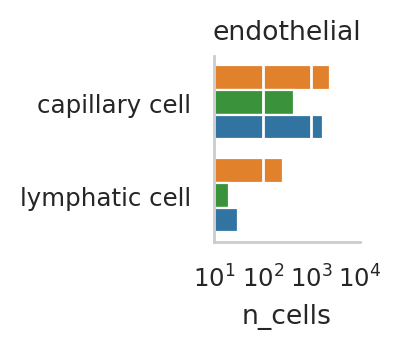

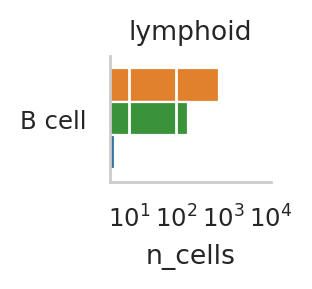

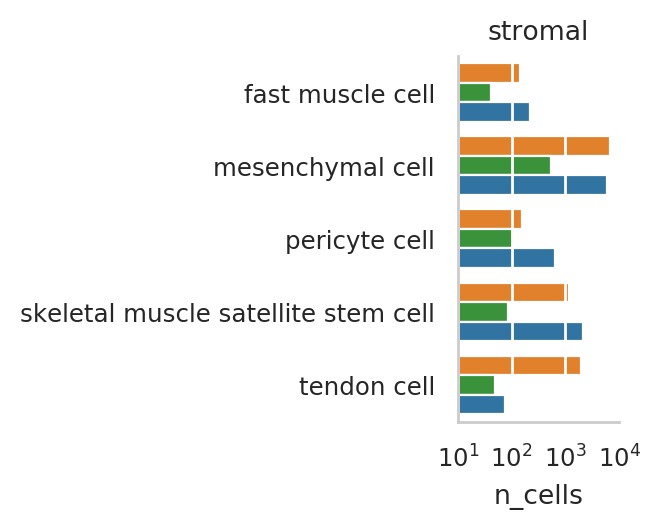

In [15]:
preprocess.plot_shared_cell_types(adata, celltype_col, compartment_col, species_col)
save_figures(os.path.join(figure_folder, 'shared_cell_types'))

# Dimensionality reduction

## Do PCA + k-nearest neighbors pre-batch correction with BBKNN

extracting highly variable genes
    finished (0:00:28)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50



 Number of highly variable genes: 3327


    finished (0:00:07)


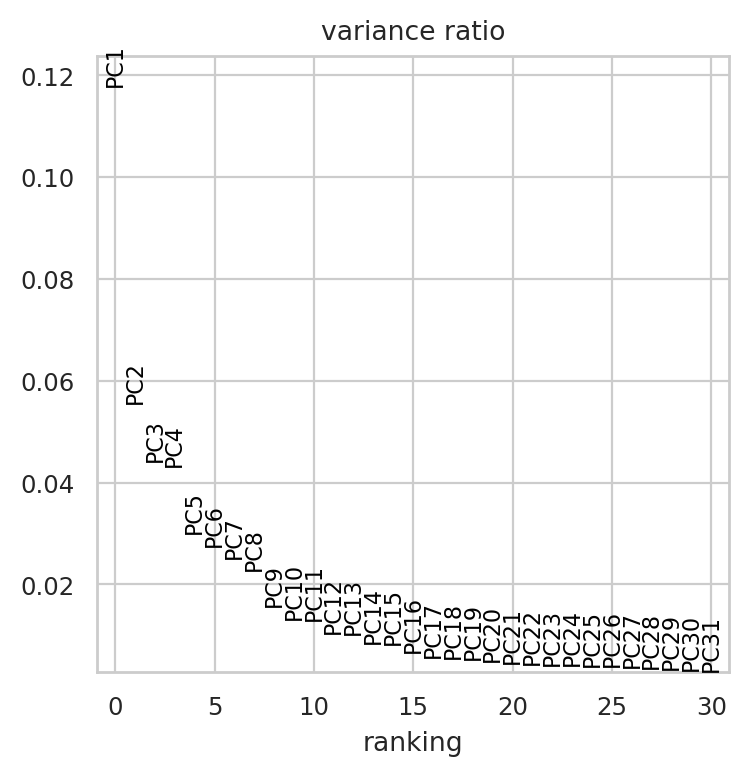

<Figure size 800x800 with 0 Axes>

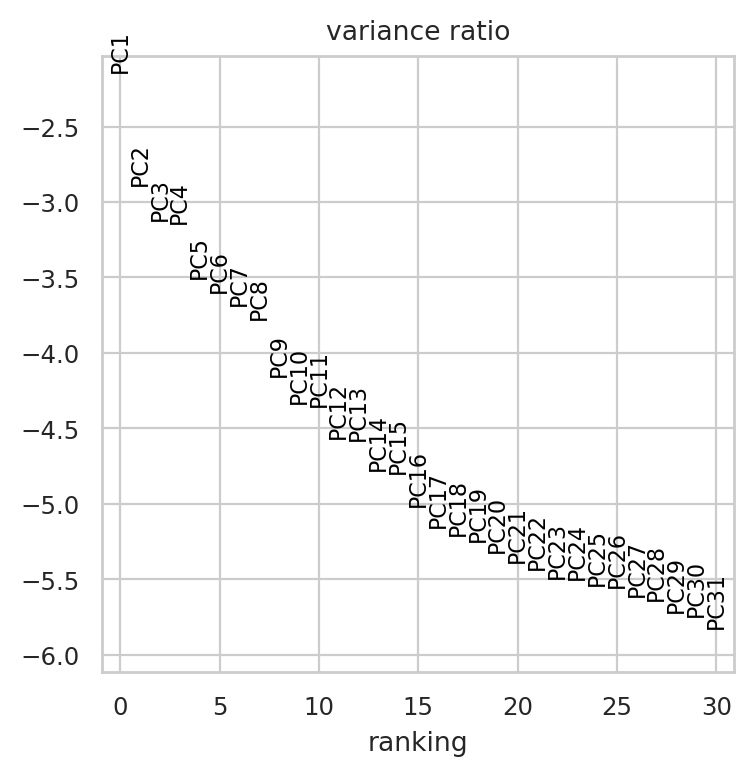

computing PCA
    on highly variable genes
    with n_comps=40
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


<Figure size 800x800 with 0 Axes>

In [16]:
adata = preprocess.dimensionality_reduction(adata)


## Pre-bbknn umaps

Error plotting with colors=['species', 'species_batch', 'age', 'individual'], skipping


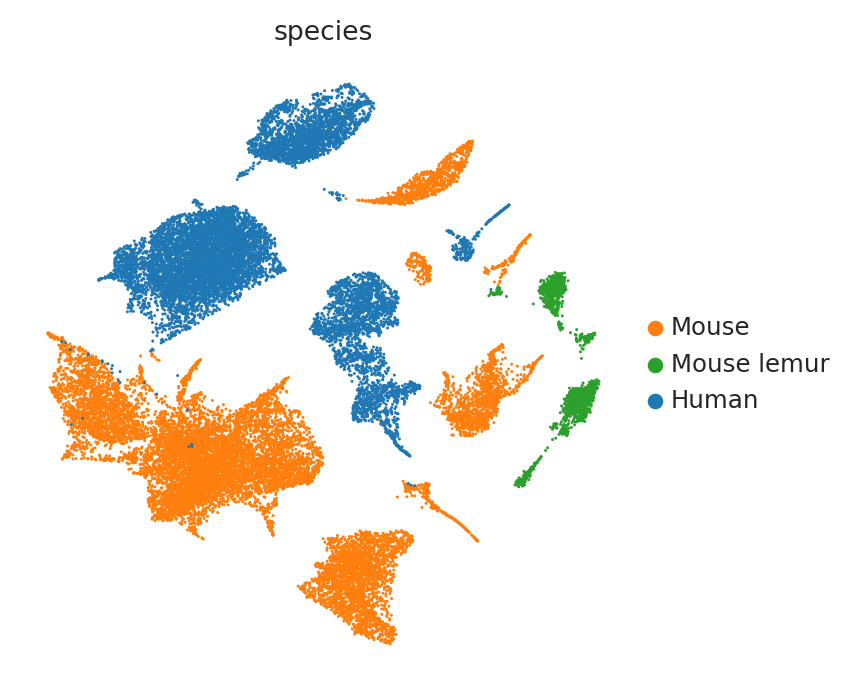

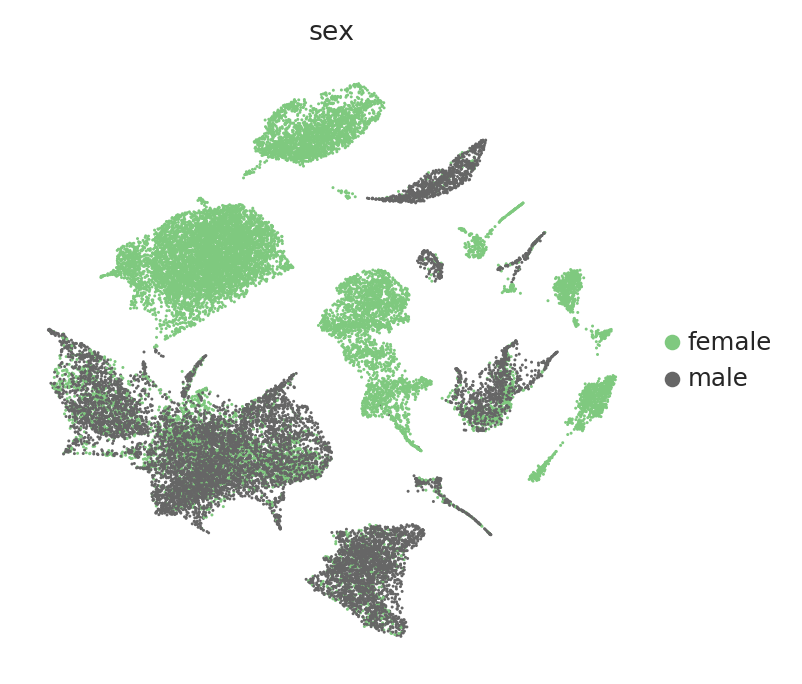

<Figure size 800x800 with 0 Axes>

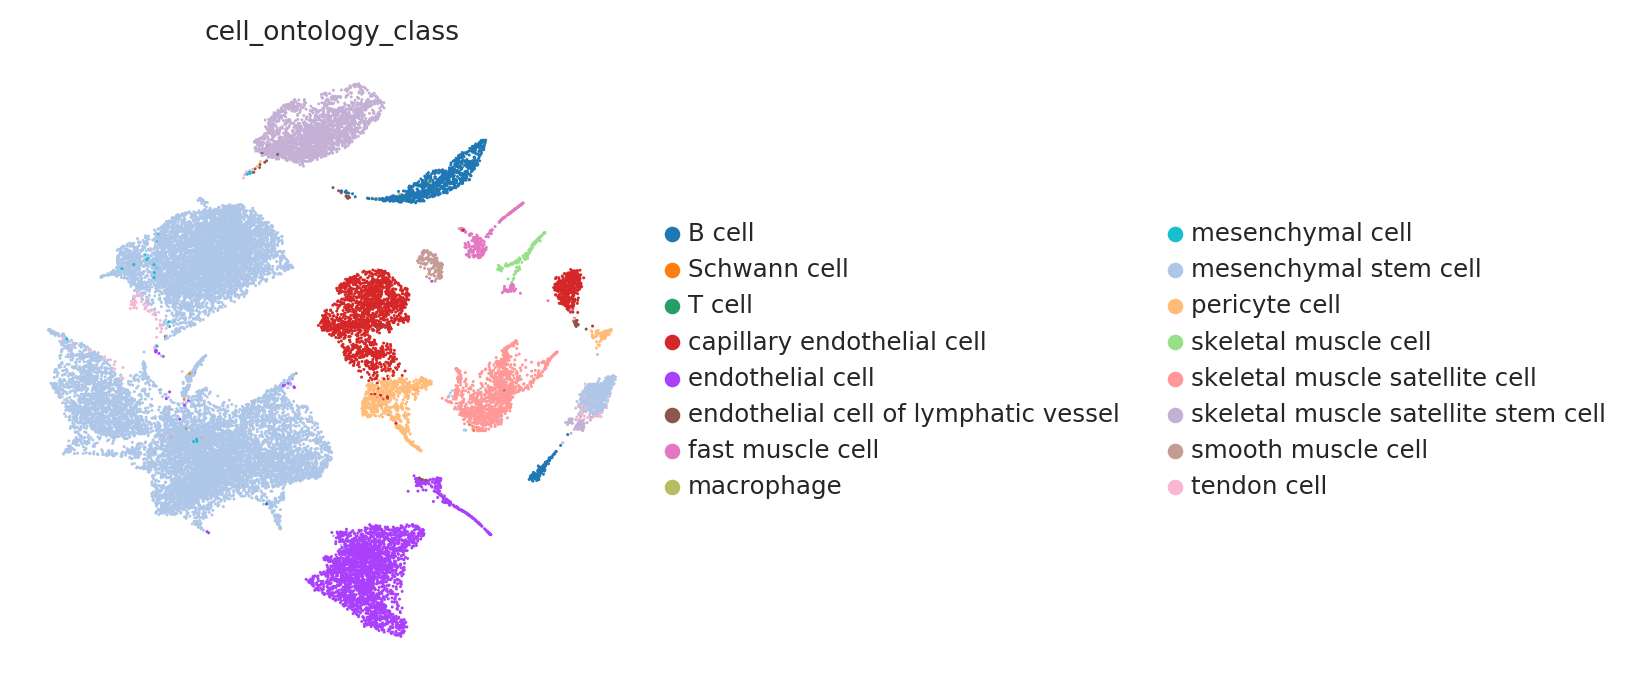

<Figure size 800x800 with 0 Axes>

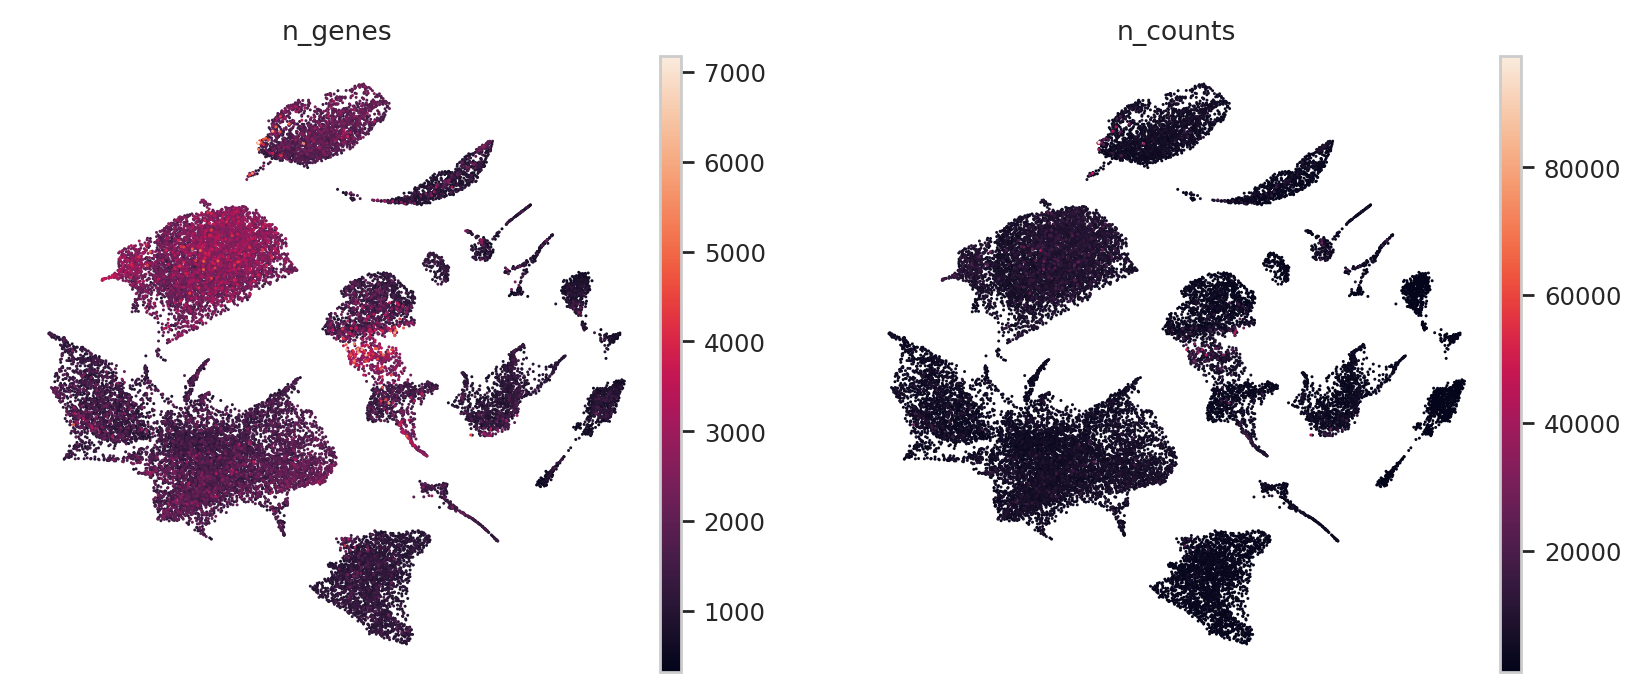

<Figure size 800x800 with 0 Axes>

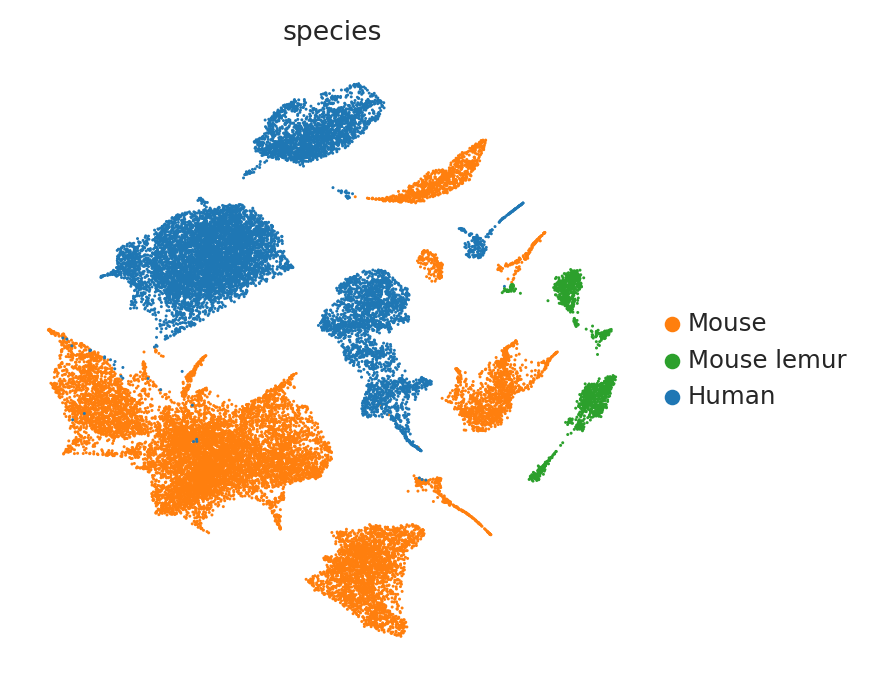

<Figure size 800x800 with 0 Axes>

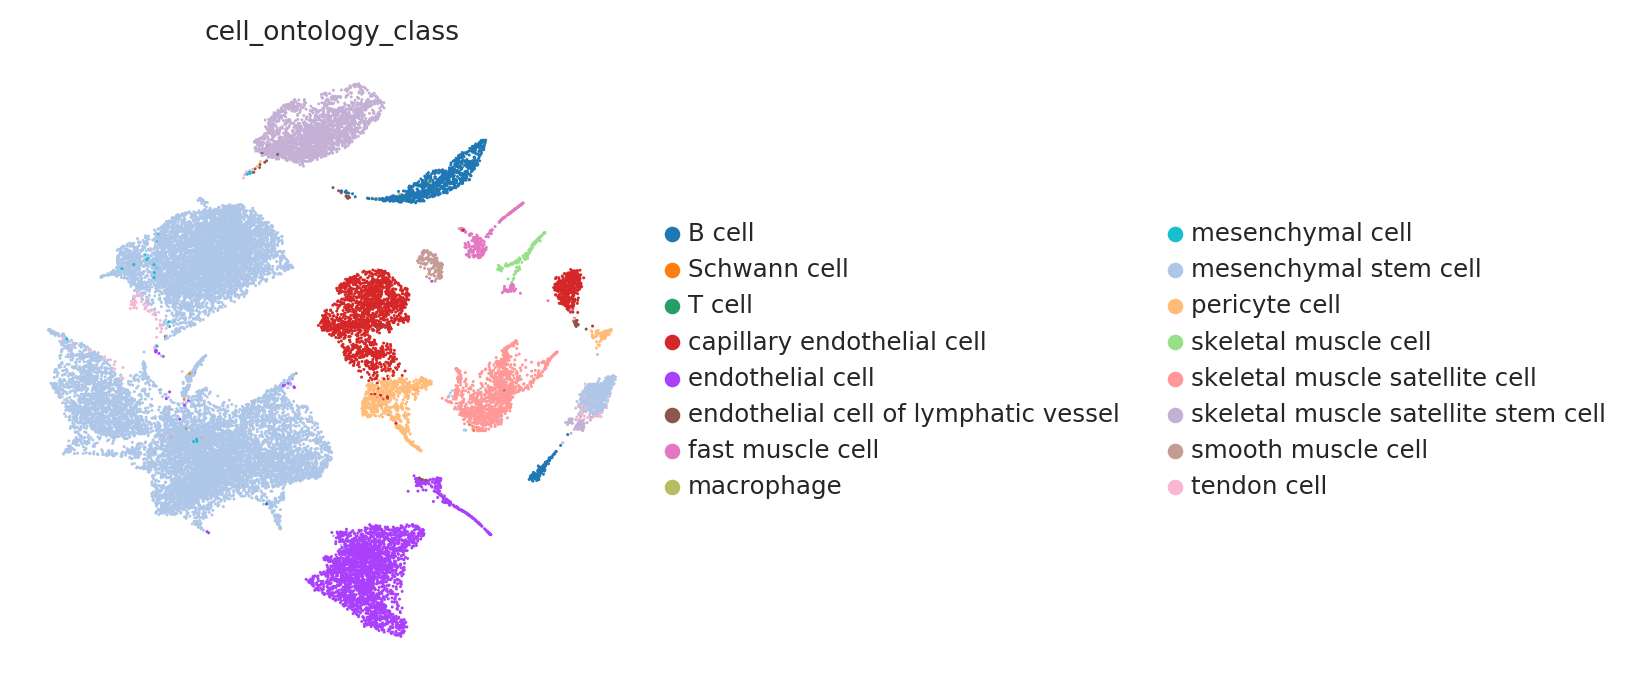

Error plotting with colors=['narrow_group', 'broad_group', 'compartment_group'], skipping
Error plotting with colors=narrow_group, skipping
Error plotting with colors=broad_group, skipping


<Figure size 800x800 with 0 Axes>

<Figure size 2898x800 with 0 Axes>

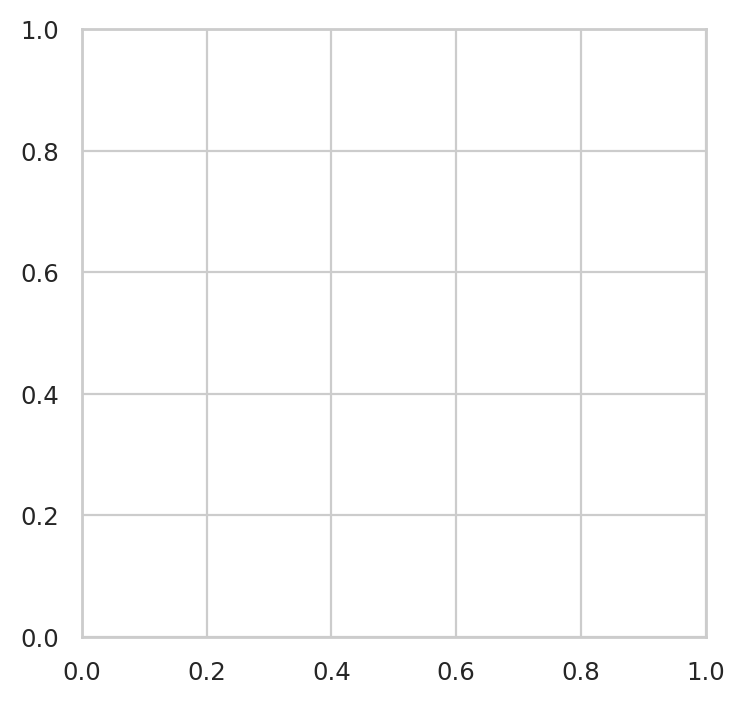

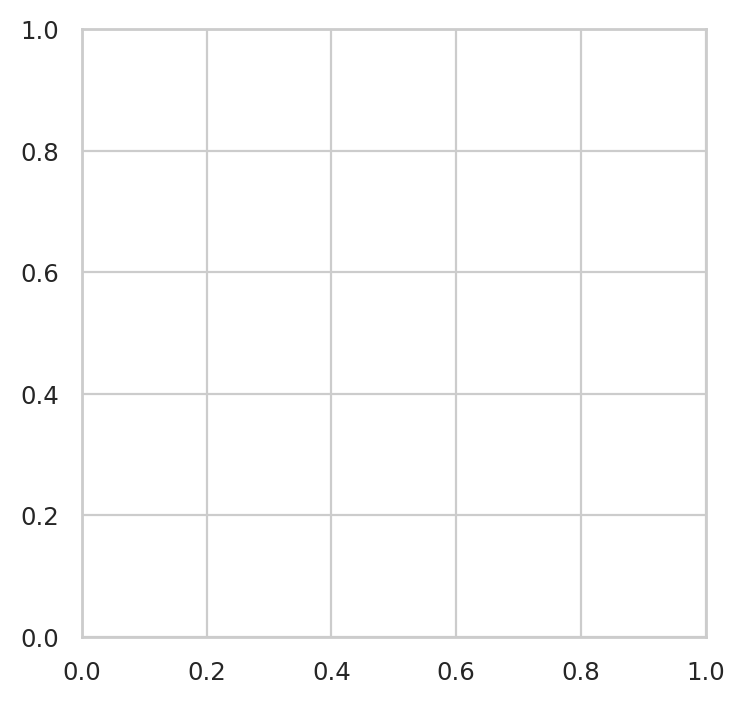

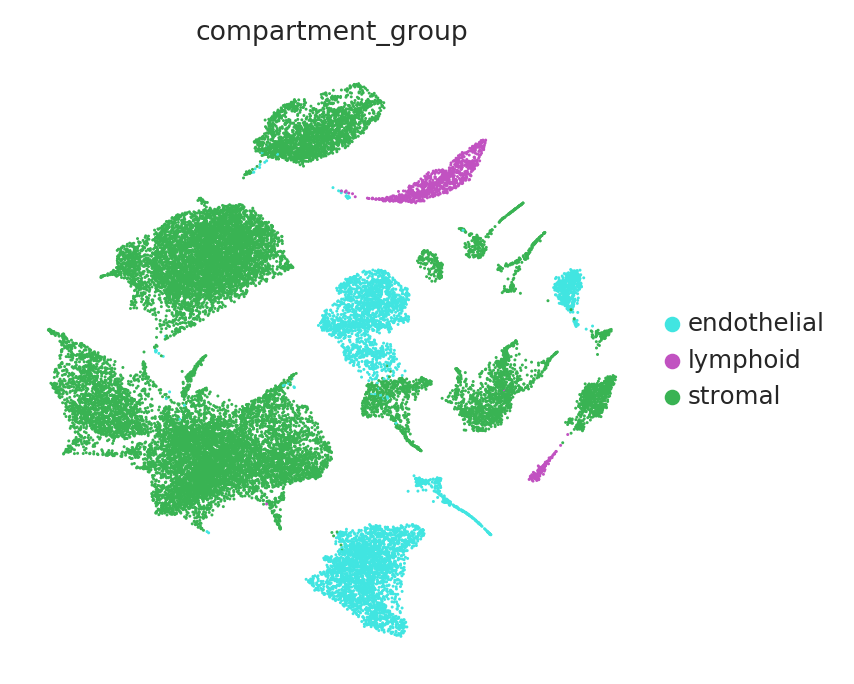

<Figure size 800x800 with 0 Axes>

In [17]:
# Pre-BBKNN UMAPs
preprocess.plot_umaps(adata)

## Do BBKNN, draw new umaps

In [18]:
preprocess.run_bbknn(adata)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


### Remove `adata.uns` palette colors because there is a bug

In [19]:
preprocess.remove_color_palettes(adata)

removing 'species_colors'
removing 'species_batch_colors'
removing 'sex_colors'
removing 'cell_ontology_class_colors'
removing 'narrow_group_colors'
removing 'broad_group_colors'
removing 'compartment_group_colors'


### Species

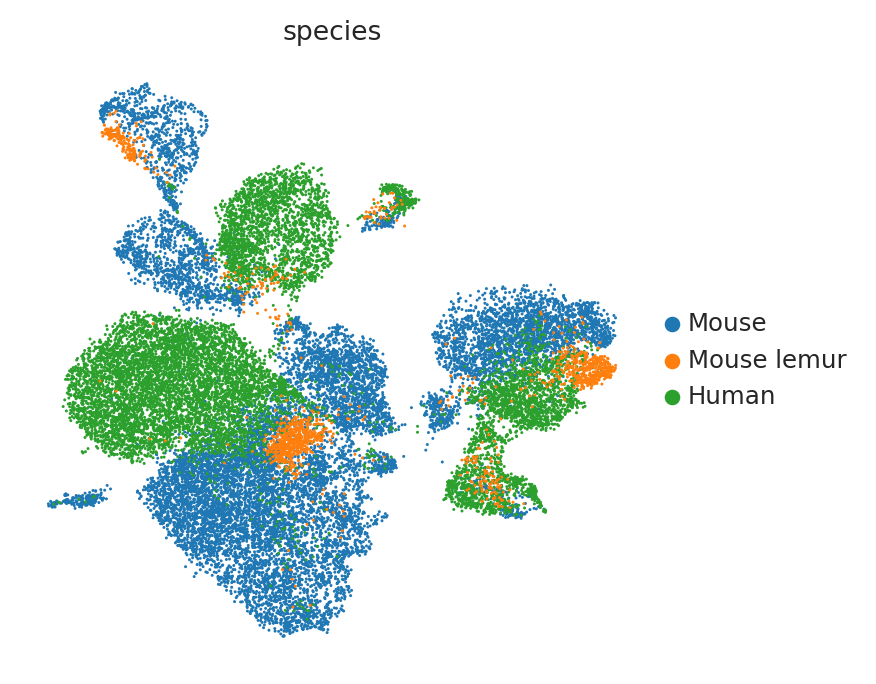

In [20]:
tab10 = sns.color_palette('tab10')
sc.pl.umap(adata, color='species', palette=tab10[:3], save='__species')

### Compartment group

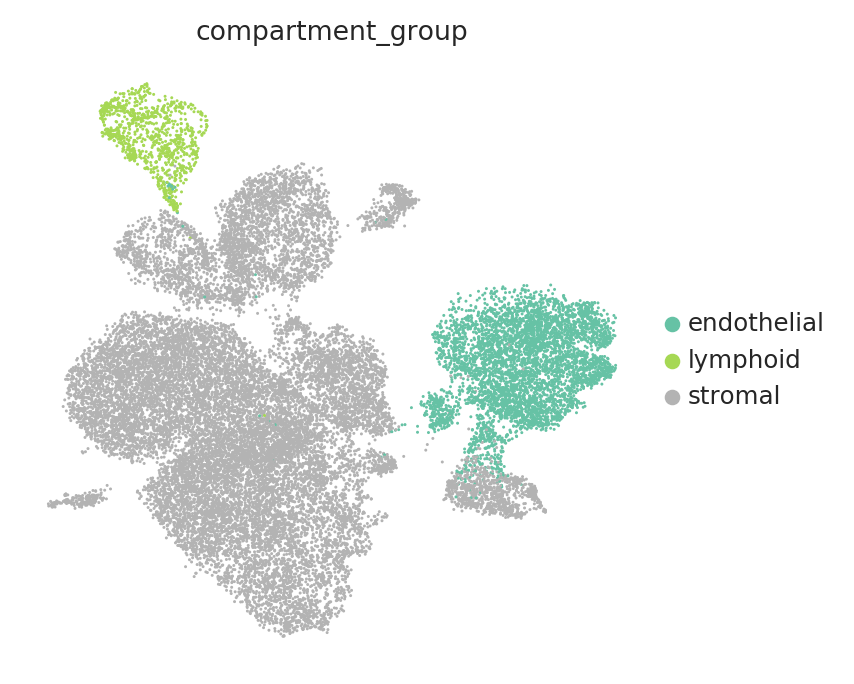

In [21]:
# there is some bug when the palette is pre-set
try:
    del adata.uns['compartment_group_colors']
except KeyError:
    pass

sc.pl.umap(adata, color='compartment_group', save='__compartment_group', palette='Set2')

### Narrow group

removing 'species_colors'
removing 'compartment_group_colors'


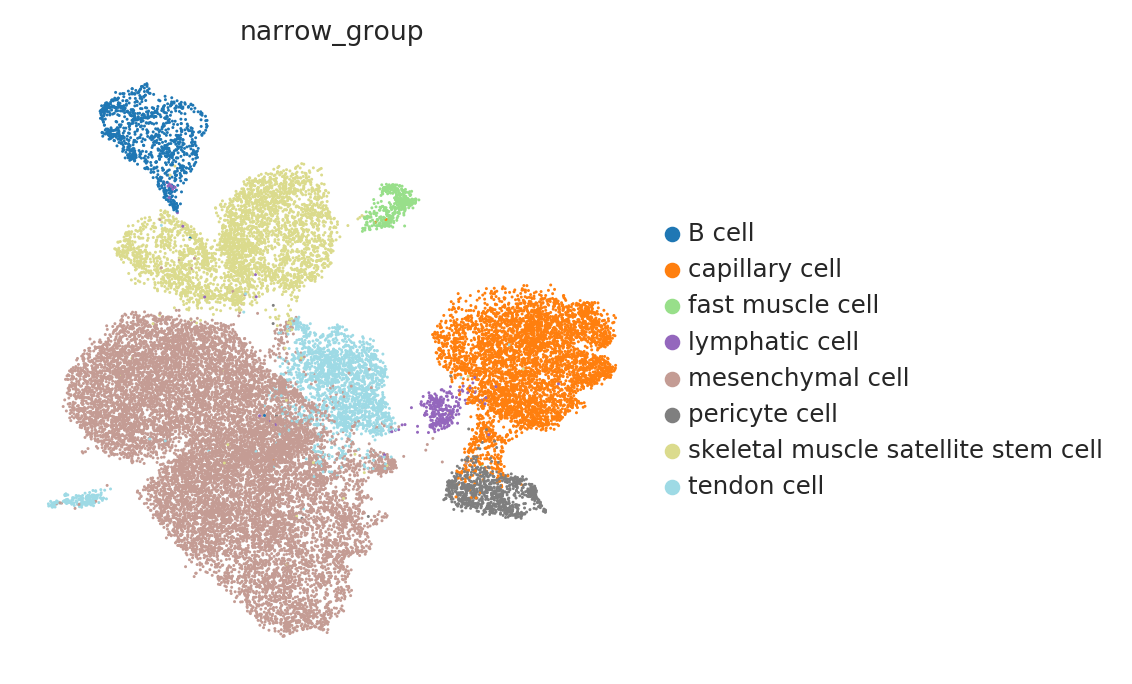

In [22]:
preprocess.remove_color_palettes(adata)
sc.pl.umap(adata, color='narrow_group', palette='tab20', save='__narrow_group')

In [23]:
preprocess.remove_color_palettes(adata)

removing 'narrow_group_colors'


... storing 'age' as categorical


Error plotting with colors=['species', 'species_batch', 'age', 'individual'], skipping


<Figure size 3864x800 with 0 Axes>

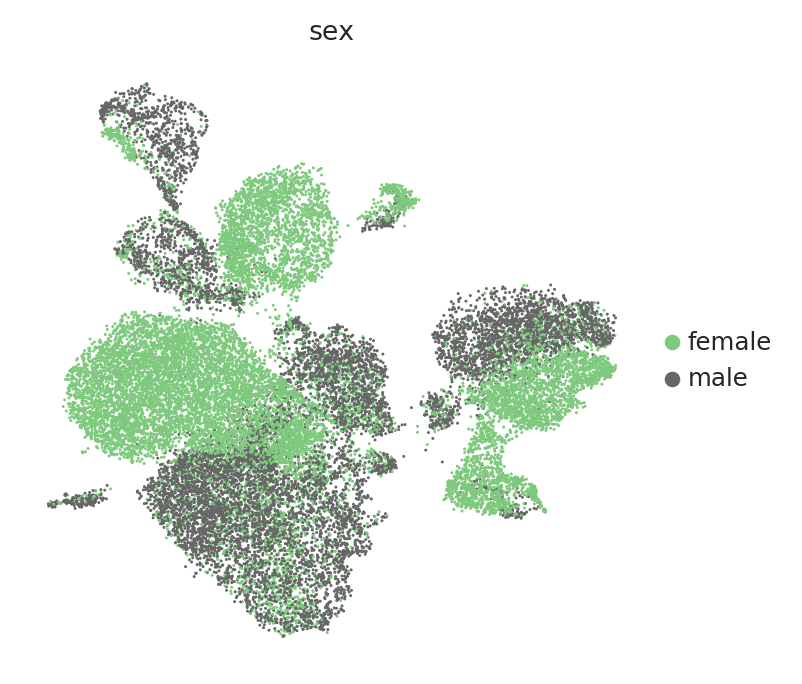

<Figure size 800x800 with 0 Axes>

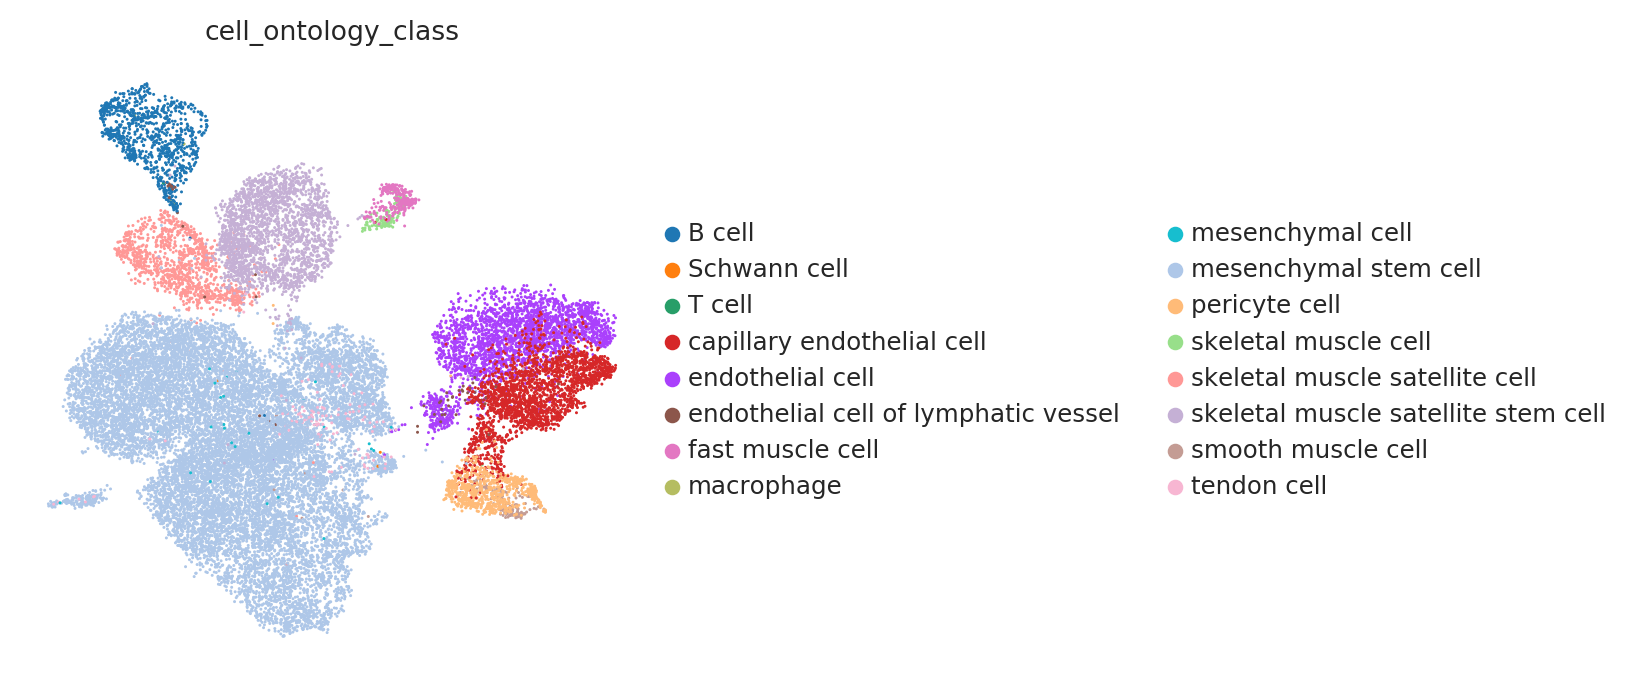

<Figure size 800x800 with 0 Axes>

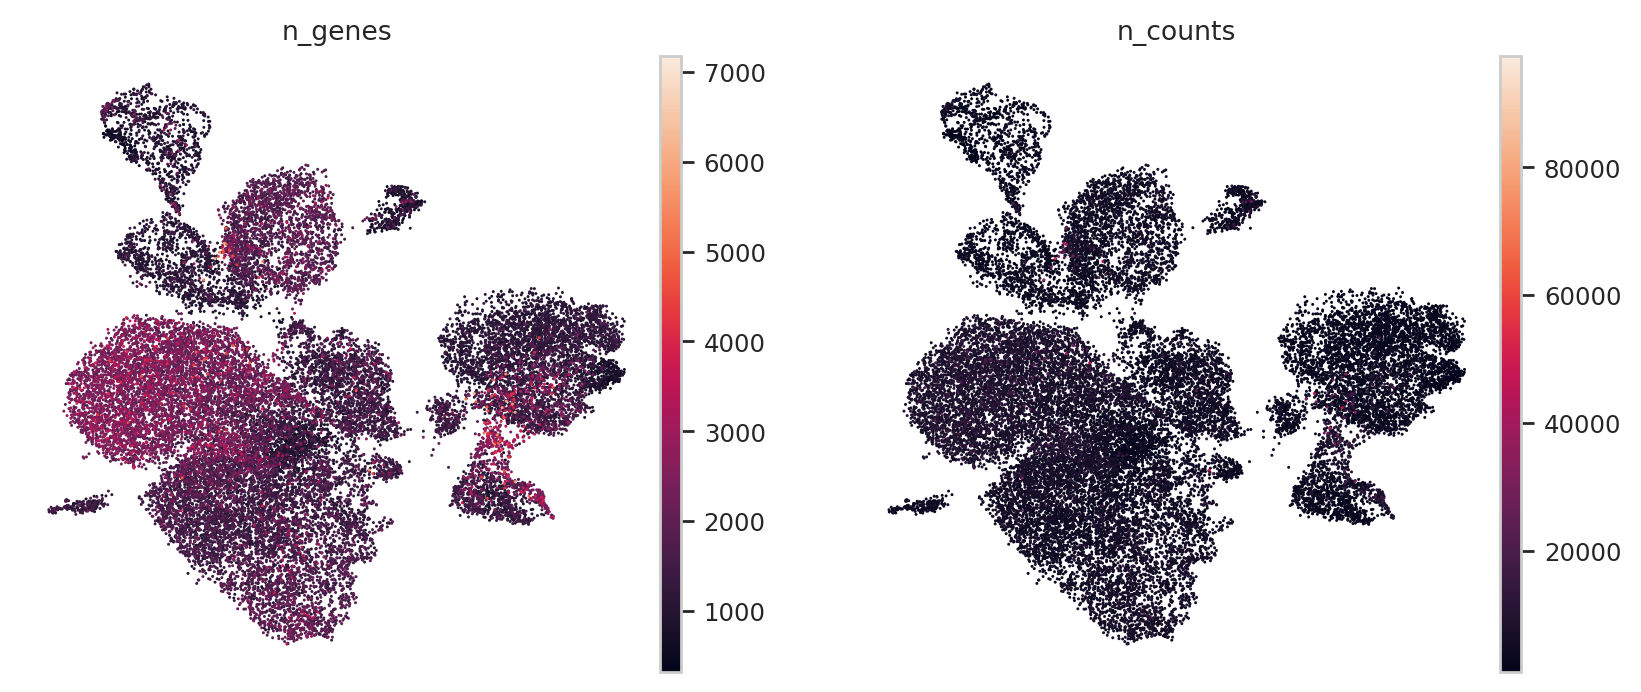

<Figure size 800x800 with 0 Axes>

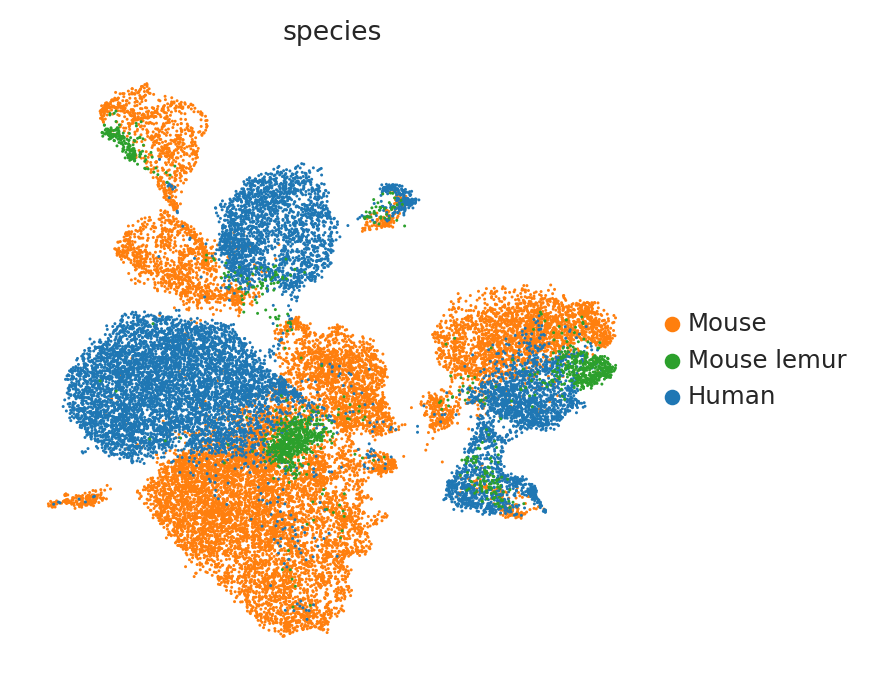

<Figure size 800x800 with 0 Axes>

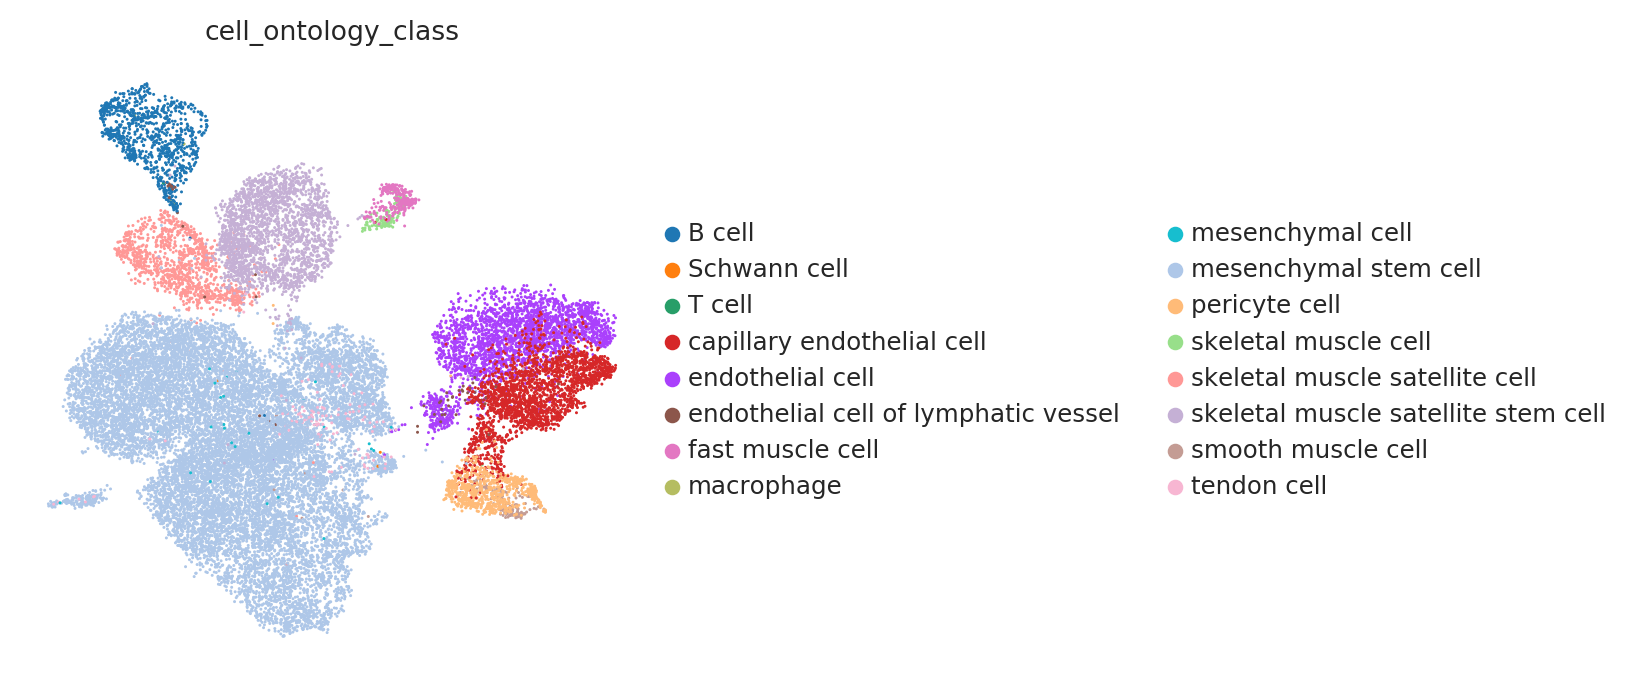

Error plotting with colors=['narrow_group', 'broad_group', 'compartment_group'], skipping
Error plotting with colors=narrow_group, skipping
Error plotting with colors=broad_group, skipping


<Figure size 800x800 with 0 Axes>

<Figure size 2898x800 with 0 Axes>

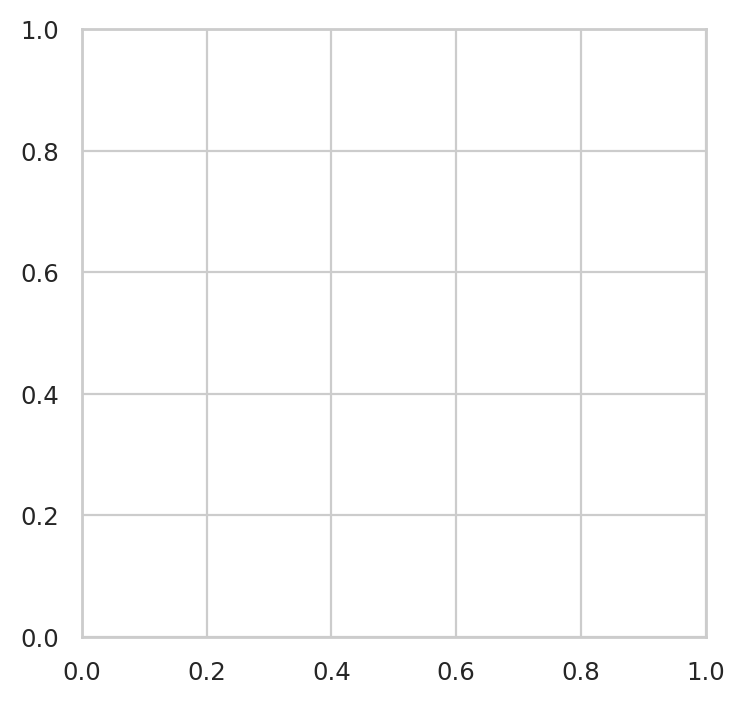

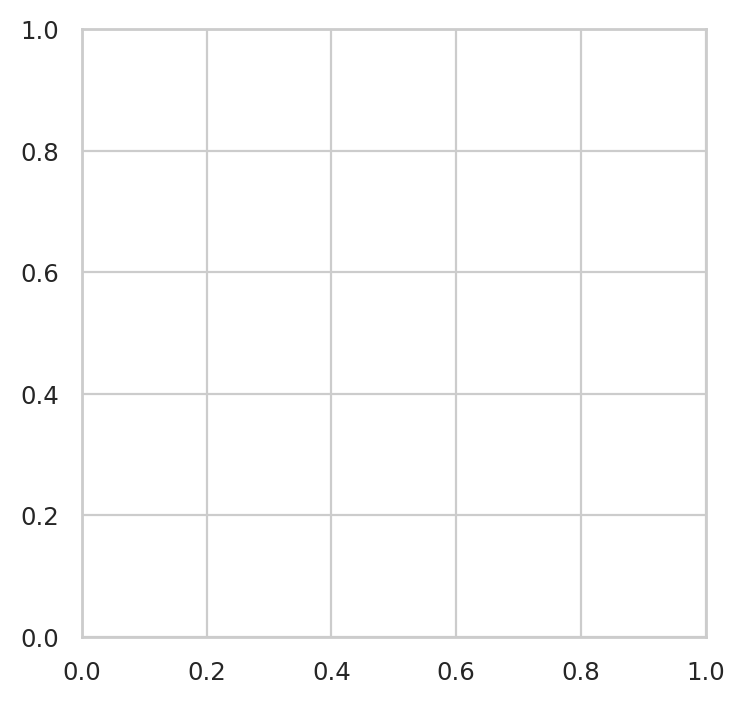

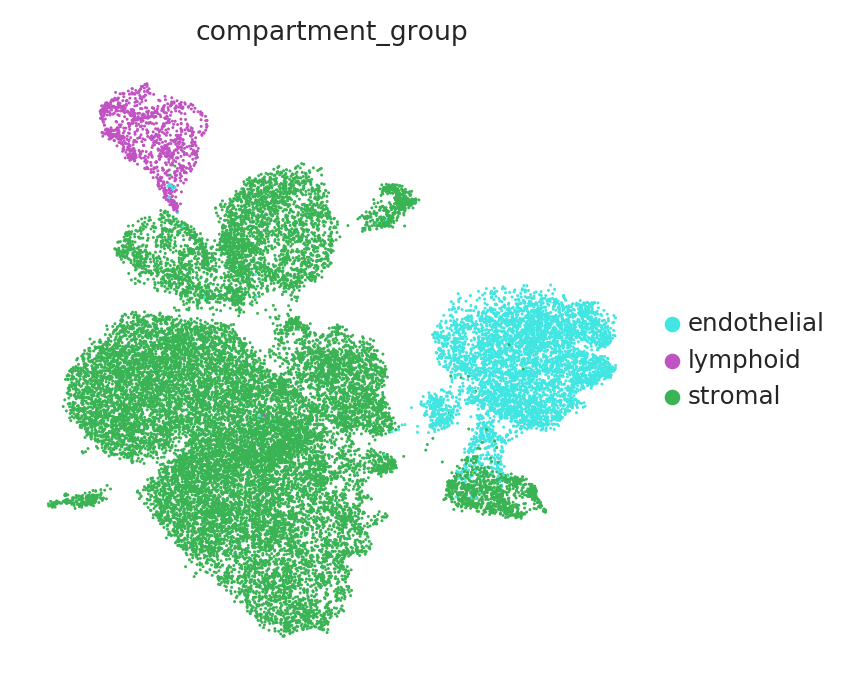

<Figure size 800x800 with 0 Axes>

In [24]:
# Post-BBKNN UMAPs 
adata.obs['age'] = adata.obs['age'].astype(str)
preprocess.plot_umaps(adata)

## Write output adata to file

In [25]:
# # Write BBKNN + UMAP data to file
adata.write(output_file)

In [26]:
output_file

'/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs__muscle__april2021__preprocessed.h5ad'

## Write narrow group names for correlations

In [35]:
' '.join([x.replace(' ',  '\\') for x in sorted(set(adata.obs['narrow_group']))])

'B\\cell capillary\\cell fast\\muscle\\cell lymphatic\\cell mesenchymal\\cell pericyte\\cell skeletal\\muscle\\satellite\\stem\\cell tendon\\cell'

In [36]:
adata.obs.groupby(['narrow_group', 'species']).size()

narrow_group                         species    
B cell                               Mouse           810
                                     Mouse lemur     181
                                     Human             5
capillary cell                       Mouse          2457
                                     Mouse lemur     437
                                     Human          1701
fast muscle cell                     Mouse           142
                                     Mouse lemur      41
                                     Human           220
lymphatic cell                       Mouse           261
                                     Mouse lemur      20
                                     Human            31
mesenchymal cell                     Mouse          6884
                                     Mouse lemur     542
                                     Human          5970
pericyte cell                        Mouse           156
                                     Mo

# Plot correlations

## Append path to import

In [62]:
sys.path.append('/home/olga/code/xspecies--olgabot/refactor-bladder-blood-lung-muscle/')

import visualize_correlation as corr_viz

## Read YAML config

### make dictionary to copy for config

In [63]:
{
    x: list(y)
    for x, y in adata.obs.groupby(["compartment_group"])
    .narrow_group.unique()
    .to_dict()
    .items()
}

{'endothelial': ['capillary cell', 'lymphatic cell'],
 'lymphoid': ['B cell'],
 'stromal': ['tendon cell',
  'mesenchymal cell',
  'skeletal muscle satellite stem cell',
  'fast muscle cell',
  'pericyte cell']}

Copy the above into `compartment_narrow` below:

In [64]:
%%file muscle_config.yml

all_groups: {
    "compartment": [ 'lymphoid', 'stromal'],
    "narrow": ['B cell',
             'capillary cell',
             'fast muscle cell',
             'lymphatic cell',
             'mesenchymal cell',
             'pericyte cell',
             'skeletal muscle satellite stem cell',
             'tendon cell',
              ],
    "broad": ['B cell',
             'endothelial cell',
             'fast muscle cell',
             'mesenchymal cell',
             'pericyte cell_smooth muscle cell',
             'skeletal muscle satellite stem cell',
             'tendon cell',
             ]
}

compartment_narrow: {'endothelial': ['capillary cell', 'lymphatic cell'],
 'lymphoid': ['B cell'],
 'stromal': ['tendon cell',
  'mesenchymal cell',
  'skeletal muscle satellite stem cell',
  'fast muscle cell',
  'pericyte cell']
                    }


Overwriting muscle_config.yml


In [65]:
config_yaml_path = 'muscle_config.yml'


with open(config_yaml_path) as file:
    config = yaml.full_load(file)
    
groups = config["all_groups"].keys()
groups

dict_keys(['compartment', 'narrow', 'broad'])

## Read dataframes

In [71]:
correl_dir = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/analyses/xi-correlation/muscle'
within_celltypes_filenames = glob.glob(os.path.join(correl_dir, 'xi__narrow_group__drop_if_either_zero*.parquet'))

dfs_within = defaultdict(list)
for filename in within_celltypes_filenames:
    for group in groups:
        if group in filename:
            # Skip macrophage because it was from old annotation
            if 'macrophage' in filename:
                continue
            df = pd.read_parquet(filename)
            df = df.rename(
                columns={group + "_group": "cell_ontology_class"})
            dfs_within[group].append(df)
            
len(dfs_within)

1

In [72]:
ls /home/olga/data_lg/data_sm_copy/tabula-microcebus/analyses/xi-correlation/muscle

xi__narrow_group__drop_if_either_zero_b_cell.parquet
xi__narrow_group__drop_if_either_zero_capillary_cell.parquet
xi__narrow_group__drop_if_either_zero_fast_muscle_cell.parquet
xi__narrow_group__drop_if_either_zero_lymphatic_cell.parquet
xi__narrow_group__drop_if_either_zero_mesenchymal_cell.parquet
xi__narrow_group__drop_if_either_zero_pericyte_cell.parquet
xi__narrow_group__drop_if_either_zero_skeletal_muscle_satellite_stem_cell.parquet
xi__narrow_group__drop_if_either_zero_tendon_cell.parquet


## Visualize correlation

### Sset output folder

In [73]:
output_folder = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species--bladder-blood-lung-muscle/muscle/correlation'
! mkdir -p $output_folder

key: all_groups
key: compartment_narrow
species2                                   Mouse  Mouse lemur
species1 cell_ontology_class iteration                       
Human    B cell              0          0.473148     0.337836
                             1          0.436776     0.335503
                             2          0.466510     0.539890
                             3          0.447287     0.433788
                             4          0.328651     0.532907


/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing 

species2                                      Human     Mouse
species1    cell_ontology_class iteration                    
Mouse lemur B cell              0          0.327803  0.455929
                                1          0.278705  0.448746
                                2          0.282529  0.438717
                                3          0.350629  0.460623
                                4          0.301050  0.322381


/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing 

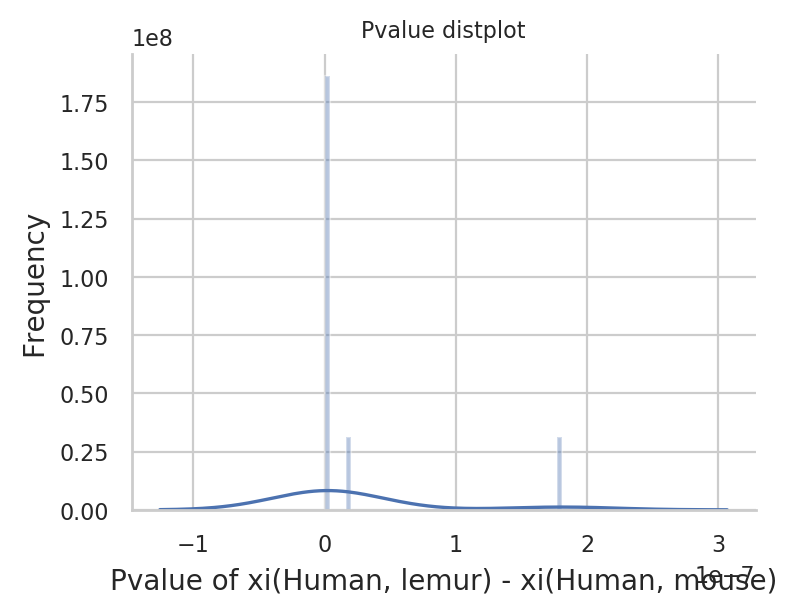

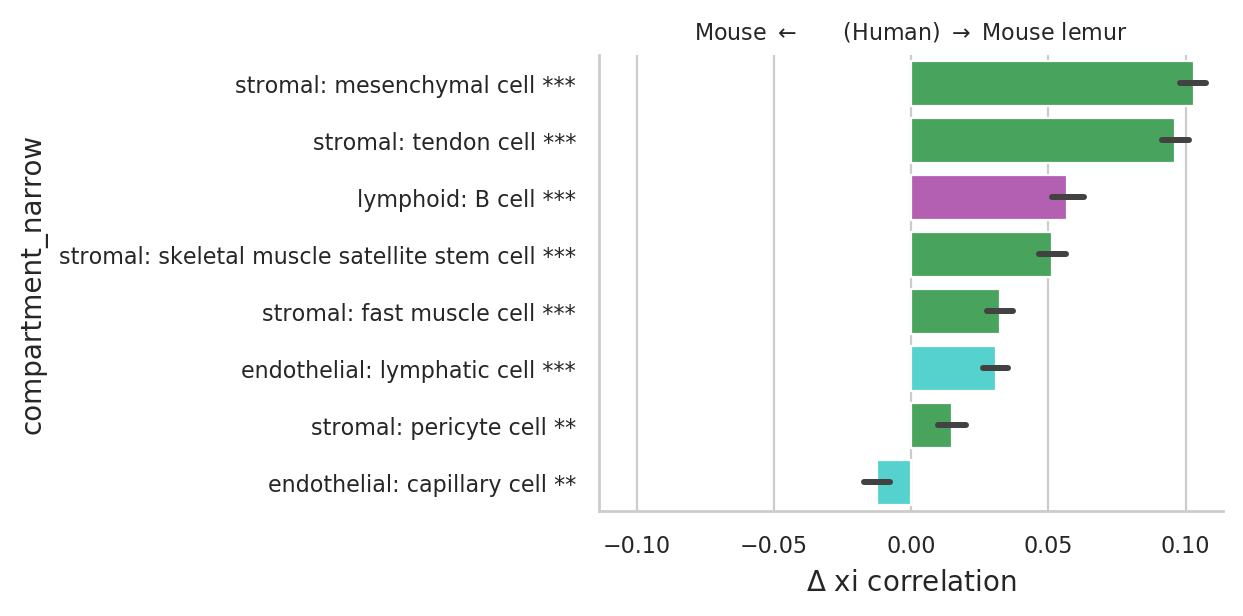

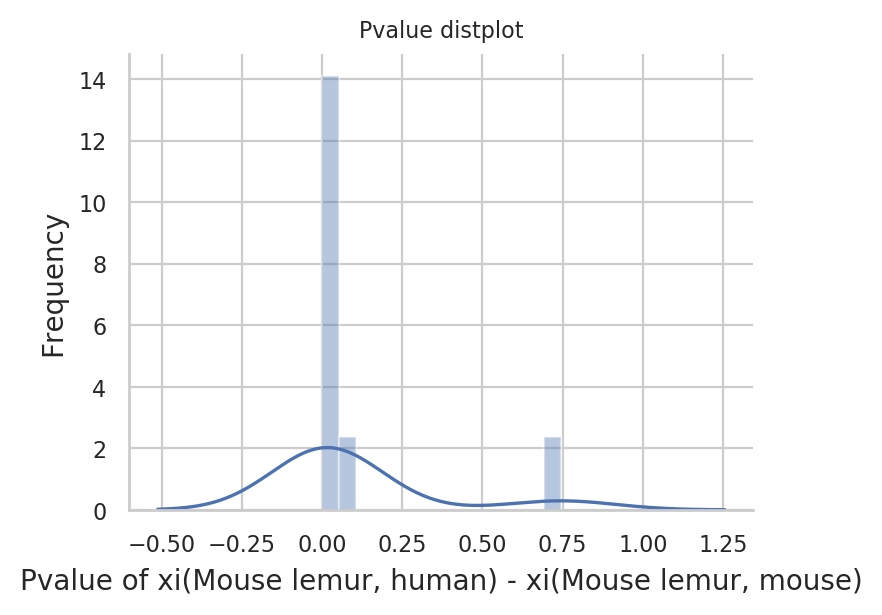

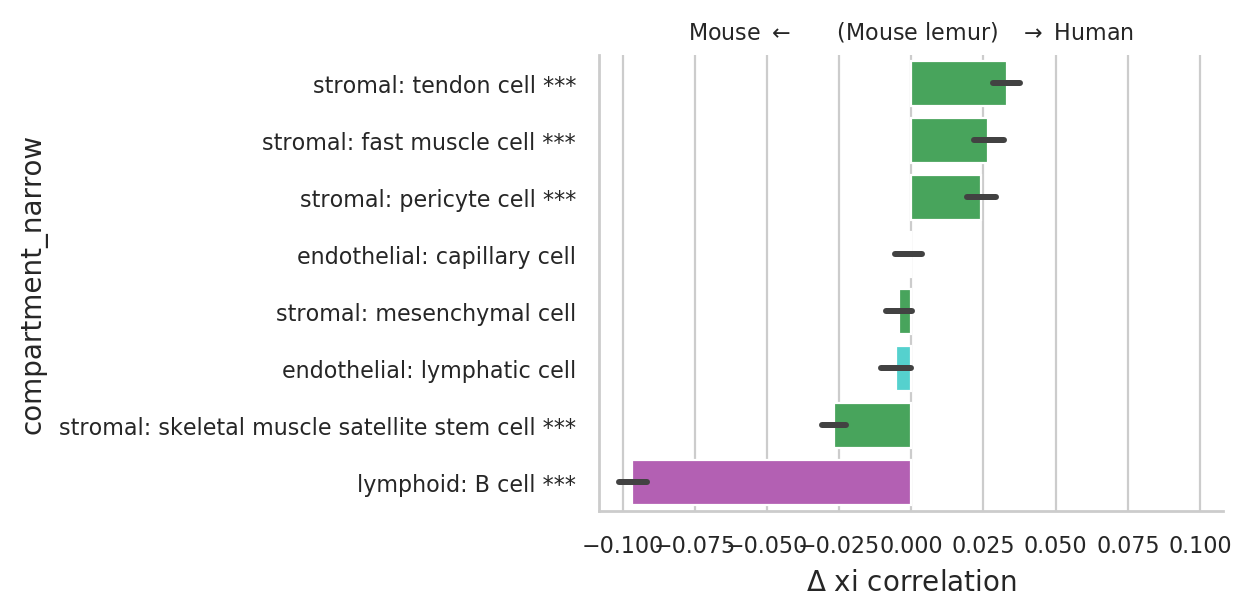

In [80]:
pvalue_level_kws=dict(level3=1e-10, level2=1e-5, level1=1e-3)

for key, dictionary in config.items():
    print(f'key: {key}')
    if "all_groups" == key:
        continue
    if "significant" in key:
        continue
#         df = pd.concat(dfs_within["narrow"], ignore_index=True)
#         narrow_celltypes_significant = []
#         for key, value in config["significant_compartment_narrow"].items():
#             narrow_celltypes_significant.extend(value)
#         df = df[df['cell_ontology_class'].isin(
#             narrow_celltypes_significant)]
    else:
        df = pd.concat(dfs_within["narrow"], ignore_index=True)
    corr_viz.corr_diff_within(df, "Human", dictionary, pvalue_level_kws=pvalue_level_kws)
    corr_viz.corr_diff_within(df, "Mouse lemur", dictionary, pvalue_level_kws=pvalue_level_kws)

for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.set_size_inches(4, 3)
    sns.despine(fig=fig)
#     fig.tight_layout()
    fig.savefig(os.path.join(output_folder, "figure%d.png" % i))
    fig.savefig(os.path.join(output_folder, "figure%d.pdf" % i))